# College Scorecard Data Analysis
## Modeling Income-Share Agreements from College Outcomes Data (US Focus)
In this notebook, we are trying to model whether a school's parameters affect the outcomes of their graduates. This is essential for creating profitable income-share agreement contracts where students' financing repayments is based on their future income.

### Kaggle Kernel Notes
We used a Kaggle Kernel given the size of our dataset and the efficiency of cloud compute and cloud storage offered by the kernel.
Below are some essential notes about this Python 3 Jupyter Notebook Environment:
- It is defined by the `kaggle/python` Docker image: https://github.com/kaggle/docker-python
- Input data files are available in the read-only `../input/` directory
- You can write up to 20GB to the current directory `/kaggle/working/` that gets preserved as output when creating version 
- You can also write temporary files to `/kaggle/temp/`, but they won't be saved outside of the current session

In [1]:
import os
import pickle
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns # advanced visualisations
import matplotlib.pyplot as plt # data visualisation

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.set_option('display.max_columns', 5000) #High dimensionality data involved
warnings.simplefilter("ignore") #Only show warnings once
plt.rcParams.update({'font.size': 20})
%matplotlib inline

/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecardDataDictionary.xlsx
/kaggle/input/college-scorecard-aggregated-dataset/InstitutionDataDocumentation.pdf
/kaggle/input/college-scorecard-aggregated-dataset/FieldOfStudyDataDocumentation.pdf
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/Most-Recent-Cohorts-Institution.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/MERGED1997_98_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/FieldOfStudyData1718_1819_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/MERGED2006_07_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/MERGED2011_12_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/MERGED2002_03_PP.csv
/kaggle/input/college-scorecard-aggregated-da

## Data Consolidation

In [3]:
# Define the file names for the year we want to import data for
years = [2001,2002,2003,2004,2005,2006,2007,2008,2009,2010] # Years of data we are interested in
fnames = list()

for year in years:
    fname = "/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data//MERGED" + str(year) + "_" + str(year+1)[2:] + "_PP.csv" #Based on format of file names
    fnames.append(fname)
print(len(fnames))

10


In [4]:
## Import first dataset – the base year dataset
data = pd.read_csv(str(fnames[0]), low_memory=False)
data["DATAYEAR"] = years[0]
dshapes = [data.shape]

## Import other datasets and concat into the base dataset
for i in range(1,len(fnames)):
    try:
        df = pd.read_csv(str(fnames[i]), low_memory=False)
        df["DATAYEAR"] = years[i]
        dshapes.append(df.shape) # Track the shape of the added data
        data = pd.concat([data, df], ignore_index=True)
    except:
        print(f"File {fnames[i]} not available")

## PrivacySuppressed has been used as an alternative to None in Object Columns    
data = data.map(lambda x: None if x == "PrivacySuppressed" else x, na_action='ignore')

## Export and visualise the data
data.to_csv("/kaggle/working/UncleanedConsolidatedData.csv")
print(data.shape, dshapes)
data.head(10)

(69360, 3233) [(6725, 3233), (6652, 3233), (6673, 3233), (6747, 3233), (6899, 3233), (6951, 3233), (6971, 3233), (7055, 3233), (7217, 3233), (7470, 3233)]


UNITID     OPEID  OPEID6                               INSTNM  \
0  100636  01230800   12308   Community College of the Air Force   
1  100654  00100200    1002             Alabama A & M University   
2  100663  00105200    1052  University of Alabama at Birmingham   
3  100690  02503400   25034                   Amridge University   
4  100706  00105500    1055  University of Alabama in Huntsville   
5  100724  00100500    1005             Alabama State University   
6  100751  00105100    1051            The University of Alabama   
7  100760  00100700    1007    Central Alabama Community College   
8  100812  00100800    1008              Athens State University   
9  100830  00831000    8310      Auburn University at Montgomery   

             CITY STABBR         ZIP  ACCREDAGENCY  INSTURL  NPCURL  SCH_DEG  \
0      Montgomery     AL  36114-3011           NaN      NaN     NaN      NaN   
1          Normal     AL       35762           NaN      NaN     NaN      3.0   
2      Birmingham     AL  35294-0110           NaN      NaN     NaN      3.0   
3      Montgomery     AL  36117-3553           NaN      NaN     NaN      3.0   
4      Huntsville     AL       35899           NaN      NaN     NaN      3.0   
5      Montgomery     AL  36104-0271           NaN      NaN     NaN      3.0   
6      Tuscaloosa     AL  35487-0100           NaN      NaN     NaN      3.0   
7  Alexander City     AL       35010           NaN      NaN     NaN      2.0   
8          Athens     AL       35611           NaN      NaN     NaN      3.0   
9      Montgomery     AL  36117-3596           NaN      NaN     NaN      3.0   

   HCM2  MAIN  NUMBRANCH  PREDDEG  HIGHDEG  CONTROL  ST_FIPS  REGION  LOCALE  \
0   NaN     1          1        2        2      1.0        1       0     NaN   
1   NaN     1          1        3        4      1.0        1       5     NaN   
2   NaN     1          1        3        4      1.0        1       5     NaN   
3   NaN     1          1        3        4      2.0        1       5     NaN   
4   NaN     1          1        3        4      1.0        1       5     NaN   
5   NaN     1          1        3        4      1.0        1       5     NaN   
6   NaN     1          1        3        4      1.0        1       5     NaN   
7   NaN     1          1        2        2      1.0        1       5     NaN   
8   NaN     1          1        3        3      1.0        1       5     NaN   
9   NaN     1          1        3        4      1.0        1       5     NaN   

   LOCALE2  LATITUDE  LONGITUDE  CCBASIC  CCUGPROF  CCSIZSET  HBCU  PBI  \
0      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
1      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
2      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
3      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
4      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
5      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
6      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
7      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
8      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
9      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   

   ANNHI  TRIBAL  AANAPII  HSI  NANTI  MENONLY  WOMENONLY  RELAFFIL  ADM_RATE  \
0    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN       NaN   
1    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN    0.7505   
2    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN    0.9098   
3    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN       NaN   
4    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN    0.8381   
5    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN       NaN   
6    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN    0.7948   
7    NaN     NaN  

## Data Cleaning

In [94]:
#Number of unique university
print(data.UNITID.nunique())
print(data.DATAYEAR.nunique())

6576
4


In [151]:
## Uncomment this if you need to import the consolidated data rather than running the code above
data = pd.read_csv("/kaggle/working/UncleanedConsolidatedData.csv", low_memory=False)

In [152]:
print(data.MN_EARN_WNE_P6.isnull().sum()/69360)
print(data.MN_EARN_WNE_P8.isnull().sum()/69360)
print(data.MN_EARN_WNE_P10.isnull().sum()/69360)

0.6810553633217993
0.7639705882352941
0.8450692041522492


In [153]:
#PrivacySuppressed has been used as an alternative to None in Object Columns
data = data.map(lambda x: None if x == "PrivacySuppressed" else x, na_action='ignore')

#Filter data to only include data where our target variable is not not null
data.dropna(subset=['MN_EARN_WNE_P6'], inplace=True) ## Target: Mean Earning after 6 years

print(data.shape)
print(data.DATAYEAR.unique()) ## Years with our Target Variable not Null

(22122, 3234)
[2003 2005 2007 2009]


## Data Relevance

In [154]:
features = '''
UNITID
INSTNM
ACCREDAGENCY
SCH_DEG
HCM2
MAIN
NUMBRANCH
PREDDEG
HIGHDEG
CONTROL
REGION
CCBASIC
CCUGPROF
CCSIZSET
ADM_RATE
SATVRMID
SATMTMID
SATWRMID
ACTCMMID
ACTENMID
ACTMTMID
ACTWRMID
DISTANCEONLY
UGDS
UG
PPTUG_EF
PPTUG_EF2
NPT4_PUB
NPT4_PRIV
NPT4_PROG
NPT4_OTHER
NUM4_PUB
NUM4_PRIV
NUM4_PROG
NUM4_OTHER
COSTT4_A
COSTT4_P
TUITIONFEE_IN
TUITIONFEE_OUT
TUITIONFEE_PROG
INEXPFTE
AVGFACSAL
PFTFAC
C150_4
C150_L4
PFTFTUG1_EF
C200_4
C200_L4
RET_FT4
RET_FTL4
RET_PT4
RET_PTL4
UG25ABV
COMP_ORIG_YR2_RT
COMP_4YR_TRANS_YR2_RT
COMP_2YR_TRANS_YR2_RT
WDRAW_ORIG_YR2_RT
WDRAW_4YR_TRANS_YR2_RT
WDRAW_2YR_TRANS_YR2_RT
COMP_ORIG_YR3_RT
COMP_4YR_TRANS_YR3_RT
COMP_2YR_TRANS_YR3_RT
WDRAW_ORIG_YR3_RT
WDRAW_4YR_TRANS_YR3_RT
WDRAW_2YR_TRANS_YR3_RT
COMP_ORIG_YR4_RT
COMP_4YR_TRANS_YR4_RT
COMP_2YR_TRANS_YR4_RT
WDRAW_ORIG_YR4_RT
WDRAW_4YR_TRANS_YR4_RT
WDRAW_2YR_TRANS_YR4_RT
COMP_ORIG_YR6_RT
COMP_4YR_TRANS_YR6_RT
COMP_2YR_TRANS_YR6_RT
WDRAW_ORIG_YR6_RT
WDRAW_4YR_TRANS_YR6_RT
WDRAW_2YR_TRANS_YR6_RT
COMP_ORIG_YR8_RT
COMP_4YR_TRANS_YR8_RT
COMP_2YR_TRANS_YR8_RT
WDRAW_ORIG_YR8_RT
WDRAW_4YR_TRANS_YR8_RT
WDRAW_2YR_TRANS_YR8_RT
INC_PCT_M1
INC_PCT_M2
INC_PCT_H1
INC_PCT_H2
OVERALL_YR2_N
OVERALL_YR3_N
OVERALL_YR4_N
OVERALL_YR6_N
OVERALL_YR8_N
AGE_ENTRY
AGEGE24
FEMALE
MARRIED
DEPENDENT
VETERAN
FIRST_GEN
FAMINC
MD_FAMINC
UNEMP_RATE
COUNT_NWNE_P6
COUNT_WNE_P6
MN_EARN_WNE_P6
C100_4
T4APPROVALDATE
OPENADMP
RET_FT4_POOLED
RET_FTL4_POOLED
RET_PT4_POOLED
RET_PTL4_POOLED
PRGMOFR
BOOKSUPPLY
ROOMBOARD_ON
OTHEREXPENSE_ON
ROOMBOARD_OFF
OTHEREXPENSE_OFF
ENDOWBEGIN
ADMCON7
STUFACR
DATAYEAR'''
feature_cols = features.split()
df = data
data = data[feature_cols]
print(data.shape)
data.head()

(22122, 122)


,UNITID,INSTNM,ACCREDAGENCY,SCH_DEG,HCM2,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,REGION,CCBASIC,CCUGPROF,CCSIZSET,ADM_RATE,SATVRMID,SATMTMID,SATWRMID,ACTCMMID,ACTENMID,ACTMTMID,ACTWRMID,DISTANCEONLY,UGDS,UG,PPTUG_EF,PPTUG_EF2,NPT4_PUB,NPT4_PRIV,NPT4_PROG,NPT4_OTHER,NUM4_PUB,NUM4_PRIV,NUM4_PROG,NUM4_OTHER,COSTT4_A,COSTT4_P,TUITIONFEE_IN,TUITIONFEE_OUT,TUITIONFEE_PROG,INEXPFTE,AVGFACSAL,PFTFAC,C150_4,C150_L4,PFTFTUG1_EF,C200_4,C200_L4,RET_FT4,RET_FTL4,RET_PT4,RET_PTL4,UG25ABV,COMP_ORIG_YR2_RT,COMP_4YR_TRANS_YR2_RT,COMP_2YR_TRANS_YR2_RT,WDRAW_ORIG_YR2_RT,WDRAW_4YR_TRANS_YR2_RT,WDRAW_2YR_TRANS_YR2_RT,COMP_ORIG_YR3_RT,COMP_4YR_TRANS_YR3_RT,COMP_2YR_TRANS_YR3_RT,WDRAW_ORIG_YR3_RT,WDRAW_4YR_TRANS_YR3_RT,WDRAW_2YR_TRANS_YR3_RT,COMP_ORIG_YR4_RT,COMP_4YR_TRANS_YR4_RT,COMP_2YR_TRANS_YR4_RT,WDRAW_ORIG_YR4_RT,WDRAW_4YR_TRANS_YR4_RT,WDRAW_2YR_TRANS_YR4_RT,COMP_ORIG_YR6_RT,COMP_4YR_TRANS_YR6_RT,COMP_2YR_TRANS_YR6_RT,WDRAW_ORIG_YR6_RT,WDRAW_4YR_TRANS_YR6_RT,WDRAW_2YR_TRANS_YR6_RT,COMP_ORIG_YR8_RT,COMP_4YR_TRANS_YR8_RT,COMP_2YR_TRANS_YR8_RT,WDRAW_ORIG_YR8_RT,WDRAW_4YR_TRANS_YR8_RT,WDRAW_2YR_TRANS_YR8_RT,INC_PCT_M1,INC_PCT_M2,INC_PCT_H1,INC_PCT_H2,OVERALL_YR2_N,OVERALL_YR3_N,OVERALL_YR4_N,OVERALL_YR6_N,OVERALL_YR8_N,AGE_ENTRY,AGEGE24,FEMALE,MARRIED,DEPENDENT,VETERAN,FIRST_GEN,FAMINC,MD_FAMINC,UNEMP_RATE,COUNT_NWNE_P6,COUNT_WNE_P6,MN_EARN_WNE_P6,C100_4,T4APPROVALDATE,OPENADMP,RET_FT4_POOLED,RET_FTL4_POOLED,RET_PT4_POOLED,RET_PTL4_POOLED,PRGMOFR,BOOKSUPPLY,ROOMBOARD_ON,OTHEREXPENSE_ON,ROOMBOARD_OFF,OTHEREXPENSE_OFF,ENDOWBEGIN,ADMCON7,STUFACR,DATAYEAR
13378,100654,Alabama A & M University,NaN,3.0,NaN,1,1,3,4,1.0,5,NaN,NaN,NaN,0.4457,NaN,NaN,NaN,18.0,17.0,17.0,NaN,NaN,5292.0,NaN,0.0669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3352.0,6184.0,NaN,3470.0,4991.0,0.7786,0.3802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1408,0.035195,NaN,NaN,0.277735,0.055853,0.026779,0.110561,0.011551,NaN,0.267327,0.069307,0.041254,0.202317,0.023166,NaN,0.276448,0.098842,0.044788,0.338362,0.064655,NaN,0.261853,0.094828,0.029095,NaN,NaN,NaN,NaN,NaN,NaN,0.179595,0.138714,0.092243,0.074773,1307.0,1212.0,1295.0,928.0,NaN,21.296296,0.12,0.522013,0.041230,0.807128,0.015024,0.405545,30708.934312,21118.5,4.91,77.0,905.0,30300.0,0.2015,NaN,2.0,NaN,NaN,NaN,NaN,NaN,900.0,4500.0,2300.0,4500.0,2300.0,NaN,1.0,NaN,2003
13379,100663,University of Alabama at Birmingham,NaN,3.0,NaN,1,1,3,4,1.0,5,NaN,NaN,NaN,0.8049,NaN,NaN,NaN,22.0,22.0,20.0,NaN,NaN,10381.0,NaN,0.2696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4274.0,9494.0,NaN,14509.0,6734.0,0.8990,0.3857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2879,0.052300,0.004843,NaN,0.273123,0.035351,0.015496,0.375320,0.011777,NaN,0.221198,0.031234,0.009217,0.365840,0.025930,0.007892,0.293123,0.046787,0.018038,0.310146,0.059623,NaN,0.305439,0.071653,0.013075,NaN,NaN,NaN,NaN,NaN,NaN,0.160661,0.152499,0.120446,0.116663,2065.0,1953.0,1774.0,1912.0,NaN,22.980490,0.26,0.649015,0.123432,0.635676,0.027872,0.395604,36616.418873,25200.0,3.57,230.0,2349.0,37500.0,0.1444,NaN,2.0,NaN,NaN,NaN,NaN,NaN,900.0,8627.0,2438.0,8823.0,3375.0,211439180.0,1.0,NaN,2003
13381,100706,University of Alabama in Huntsville,NaN,3.0,NaN,1,1,3,4,1.0,5,NaN,NaN,NaN,0.8756,575.0,570.0,NaN,25.0,25.0,23.0,NaN,NaN,4966.0,NaN,0.2424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4126.0,8702.0,NaN,5926.0,6257.0,0.5884,0.4369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2830,0.084650,NaN,NaN,0.229120,0.045147,0.013544,0.168979,0.020177,NaN,0.266078,0.054224,0.026482,0.228172,0.044237,NaN,0.298021,0.067520,0.029104,0.305981,0.061196,NaN,0.283727,0.118220,0.034771,NaN,NaN,NaN,NaN,NaN,NaN,0.154124,0.167010,0.152577,0.130928,886.0,793.0,859.0,719.0,NaN,23.485567,0.27,0.558763,0.182474,0.618041,0.034536,0.388951,41030.082474,30624.0,3.58,75.0,841.0,40600.0,0.0909,NaN,2.0,NaN,NaN,NaN,NaN,NaN,720.0,6380.0,2015.0,6380.0,2280.0,18033185.0,1.0,NaN,2003
13382,100724,Alabama State University,NaN,3.0,NaN,1,1,3,4,1.0,5,NaN,NaN,NaN,0.5042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941.0,NaN,0.1407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Data Cleaning
* Impute missing values
* Encode categorical features

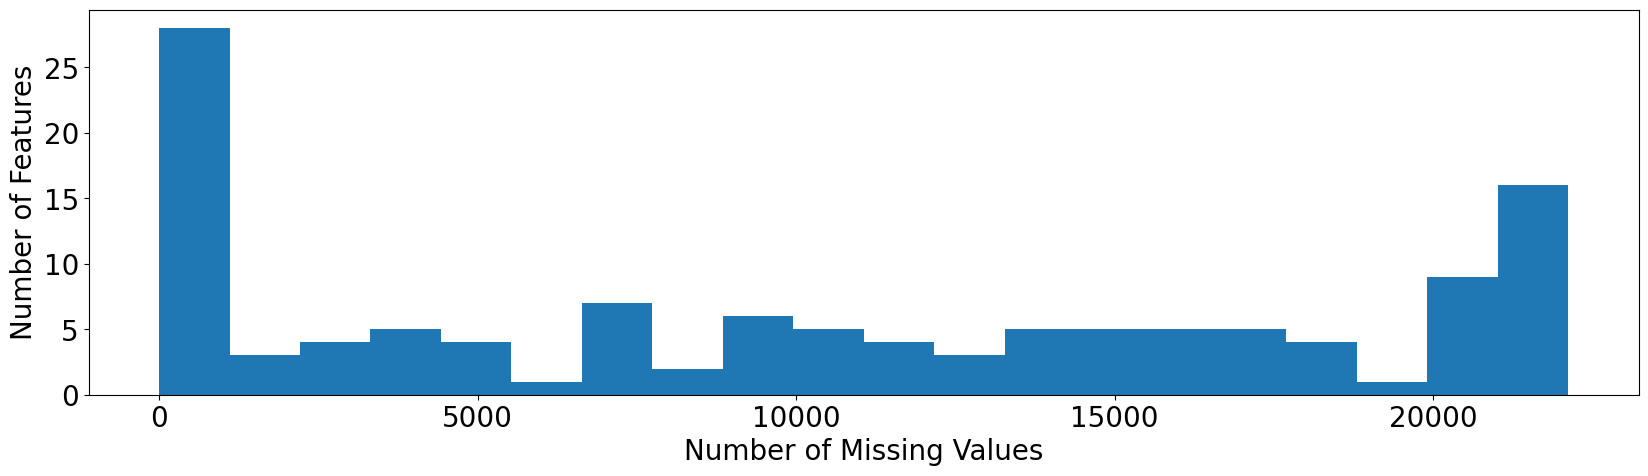

In [155]:
missing_values = data.isnull().sum(axis=0) # Identify all null values in the data
plt.figure(figsize=(20,5))
plt.hist(missing_values,bins=20,label=True)
plt.ylabel("Number of Features")
plt.xlabel("Number of Missing Values")

plt.savefig('/kaggle/working/missing_values_histogram.png')
plt.show()

In [156]:
missing_cols = list()
threshold = 0.5 * data.shape[0] #1738 seems to be the number from 0.2 to 0.4
for column in list(data.columns):
    if data[column].isnull().sum() > threshold:
        missing_cols.append(column)
        
print(f"Drop {len(missing_cols)/data.shape[1]*100}% of the columns")

Drop 46.72131147540984% of the columns


In [157]:
print(missing_cols)

['ACCREDAGENCY', 'HCM2', 'CCBASIC', 'CCUGPROF', 'CCSIZSET', 'ADM_RATE', 'SATVRMID', 'SATMTMID', 'SATWRMID', 'ACTCMMID', 'ACTENMID', 'ACTMTMID', 'ACTWRMID', 'DISTANCEONLY', 'UG', 'PPTUG_EF2', 'NPT4_PUB', 'NPT4_PRIV', 'NPT4_PROG', 'NPT4_OTHER', 'NUM4_PUB', 'NUM4_PRIV', 'NUM4_PROG', 'NUM4_OTHER', 'COSTT4_A', 'COSTT4_P', 'TUITIONFEE_PROG', 'C150_4', 'PFTFTUG1_EF', 'C200_4', 'C200_L4', 'RET_FT4', 'RET_FTL4', 'RET_PT4', 'RET_PTL4', 'COMP_4YR_TRANS_YR2_RT', 'COMP_2YR_TRANS_YR2_RT', 'COMP_4YR_TRANS_YR3_RT', 'COMP_2YR_TRANS_YR3_RT', 'COMP_2YR_TRANS_YR4_RT', 'COMP_2YR_TRANS_YR6_RT', 'COMP_4YR_TRANS_YR8_RT', 'COMP_2YR_TRANS_YR8_RT', 'WDRAW_2YR_TRANS_YR8_RT', 'AGEGE24', 'UNEMP_RATE', 'C100_4', 'T4APPROVALDATE', 'RET_FT4_POOLED', 'RET_FTL4_POOLED', 'RET_PT4_POOLED', 'RET_PTL4_POOLED', 'PRGMOFR', 'ROOMBOARD_ON', 'OTHEREXPENSE_ON', 'ENDOWBEGIN', 'STUFACR']


In [158]:
data = data.drop(missing_cols,axis=1) ## Drop columns with extreme missingness
data = data.drop_duplicates() ## Drop duplicate rows

print(data.shape)
data.head()

(22122, 65)


,UNITID,INSTNM,SCH_DEG,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,REGION,UGDS,PPTUG_EF,TUITIONFEE_IN,TUITIONFEE_OUT,INEXPFTE,AVGFACSAL,PFTFAC,C150_L4,UG25ABV,COMP_ORIG_YR2_RT,WDRAW_ORIG_YR2_RT,WDRAW_4YR_TRANS_YR2_RT,WDRAW_2YR_TRANS_YR2_RT,COMP_ORIG_YR3_RT,WDRAW_ORIG_YR3_RT,WDRAW_4YR_TRANS_YR3_RT,WDRAW_2YR_TRANS_YR3_RT,COMP_ORIG_YR4_RT,COMP_4YR_TRANS_YR4_RT,WDRAW_ORIG_YR4_RT,WDRAW_4YR_TRANS_YR4_RT,WDRAW_2YR_TRANS_YR4_RT,COMP_ORIG_YR6_RT,COMP_4YR_TRANS_YR6_RT,WDRAW_ORIG_YR6_RT,WDRAW_4YR_TRANS_YR6_RT,WDRAW_2YR_TRANS_YR6_RT,COMP_ORIG_YR8_RT,WDRAW_ORIG_YR8_RT,WDRAW_4YR_TRANS_YR8_RT,INC_PCT_M1,INC_PCT_M2,INC_PCT_H1,INC_PCT_H2,OVERALL_YR2_N,OVERALL_YR3_N,OVERALL_YR4_N,OVERALL_YR6_N,OVERALL_YR8_N,AGE_ENTRY,FEMALE,MARRIED,DEPENDENT,VETERAN,FIRST_GEN,FAMINC,MD_FAMINC,COUNT_NWNE_P6,COUNT_WNE_P6,MN_EARN_WNE_P6,OPENADMP,BOOKSUPPLY,ROOMBOARD_OFF,OTHEREXPENSE_OFF,ADMCON7,DATAYEAR
13378,100654,Alabama A & M University,3.0,1,1,3,4,1.0,5,5292.0,0.0669,3352.0,6184.0,3470.0,4991.0,0.7786,NaN,0.1408,0.035195,0.277735,0.055853,0.026779,0.110561,0.267327,0.069307,0.041254,0.202317,0.023166,0.276448,0.098842,0.044788,0.338362,0.064655,0.261853,0.094828,0.029095,NaN,NaN,NaN,0.179595,0.138714,0.092243,0.074773,1307.0,1212.0,1295.0,928.0,NaN,21.296296,0.522013,0.041230,0.807128,0.015024,0.405545,30708.934312,21118.5,77.0,905.0,30300.0,2.0,900.0,4500.0,2300.0,1.0,2003
13379,100663,University of Alabama at Birmingham,3.0,1,1,3,4,1.0,5,10381.0,0.2696,4274.0,9494.0,14509.0,6734.0,0.8990,NaN,0.2879,0.052300,0.273123,0.035351,0.015496,0.375320,0.221198,0.031234,0.009217,0.365840,0.025930,0.293123,0.046787,0.018038,0.310146,0.059623,0.305439,0.071653,0.013075,NaN,NaN,NaN,0.160661,0.152499,0.120446,0.116663,2065.0,1953.0,1774.0,1912.0,NaN,22.980490,0.649015,0.123432,0.635676,0.027872,0.395604,36616.418873,25200.0,230.0,2349.0,37500.0,2.0,900.0,8823.0,3375.0,1.0,2003
13381,100706,University of Alabama in Huntsville,3.0,1,1,3,4,1.0,5,4966.0,0.2424,4126.0,8702.0,5926.0,6257.0,0.5884,NaN,0.2830,0.084650,0.229120,0.045147,0.013544,0.168979,0.266078,0.054224,0.026482,0.228172,0.044237,0.298021,0.067520,0.029104,0.305981,0.061196,0.283727,0.118220,0.034771,NaN,NaN,NaN,0.154124,0.167010,0.152577,0.130928,886.0,793.0,859.0,719.0,NaN,23.485567,0.558763,0.182474,0.618041,0.034536,0.388951,41030.082474,30624.0,75.0,841.0,40600.0,2.0,720.0,6380.0,2280.0,1.0,2003
13382,100724,Alabama State University,3.0,1,1,3,4,1.0,5,4941.0,0.1407,3600.0,7200.0,3774.0,5017.0,0.5690,NaN,0.1349,0.030162,0.295824,0.063805,0.030742,0.111984,0.280943,0.094303,0.038638,0.137657,0.023163,0.321641,0.105890,0.048974,0.207105,0.040816,0.345427,0.144369,0.042328,NaN,NaN,NaN,0.189034,0.123599,0.072402,0.038473,1724.0,1527.0,1511.0,1323.0,NaN,21.090276,0.555286,0.033323,0.828537,0.015450,0.443433,24636.551045,18597.0,166.0,1287.0,25300.0,2.0,800.0,5625.0,2820.0,1.0,2003
13383,100751,The University of Alabama,3.0,1,1,3,4,1.0,5,15548.0,0.0902,4134.0,11294.0,6358.0,6551.0,0.8269,NaN,0.1130,0.092308,0.152991,0.026068,0.013675,0.268154,0.178517,0.046520,0.023449,0.434199,0.030176,0.201593,0.059095,0.018860,0.409828,0.071253,0.297789,0.081572,0.018673,NaN,NaN,NaN,0.129356,0.157852,0.168102,0.234932,2340.0,2644.0,2386.0,2035.0,NaN,21.283108,0.554121,0.061501,0.825953,0.019475,0.321429,53822.031980,41883.5,143.0,2337.0,37900.0,2.0,800.0,7102.0,2722.0,1.0,2003


In [159]:
df[['NPT4_PUB', 'NPT4_PRIV', 'NPT4_PROG', 'NPT4_OTHER']].describe()

,NPT4_PUB,NPT4_PRIV,NPT4_PROG,NPT4_OTHER
count,1646.000000,1925.000000,1624.000000,206.000000
mean,8394.737546,19899.634286,20383.128079,23575.941748
std,4064.711413,7148.126577,10020.406505,7644.769405
min,-544.000000,-20295.000000,-2430.000000,5092.000000
25%,5456.250000,15531.000000,13755.250000,18545.000000
50%,7793.500000,19567.000000,19715.000000,23170.500000
75%,11033.250000,23679.000000,25188.750000,27146.500000
max,25137.000000,54417.000000,78372.000000,53083.000000


In [160]:
npt4_cons = df[['NPT4_PUB', 'NPT4_PRIV', 'NPT4_PROG', 'NPT4_OTHER']].mean(axis=1,skipna=True)
npt4_cons.describe()

count     5401.000000
mean     16679.018330
std       9284.016207
min     -20295.000000
25%       9341.000000
50%      16112.000000
75%      22540.000000
max      78372.000000
dtype: float64

In [161]:
data['NPT4_CONS'] = npt4_cons
data['NPT4_MISS'] = data['NPT4_CONS'].isnull().replace({True: 1, False: 0})

In [162]:
df[['NUM4_PUB', 'NUM4_PRIV', 'NUM4_PROG', 'NUM4_OTHER']].describe()

,NUM4_PUB,NUM4_PRIV,NUM4_PROG,NUM4_OTHER
count,1648.000000,1945.000000,1635.00000,209.000000
mean,500.391990,226.719280,262.21896,285.794258
std,536.361798,330.473816,526.40663,588.737217
min,0.000000,0.000000,0.00000,0.000000
25%,144.000000,53.000000,50.00000,20.000000
50%,307.000000,143.000000,111.00000,147.000000
75%,647.000000,292.000000,299.00000,359.000000
max,4087.000000,7590.000000,12888.00000,6600.000000


In [163]:
num4_cons = df[['NUM4_PUB', 'NUM4_PRIV', 'NUM4_PROG', 'NUM4_OTHER']].mean(axis=1,skipna=True)
num4_cons.describe()

count     5437.000000
mean       322.617988
std        486.617543
min          0.000000
25%         65.000000
50%        173.000000
75%        395.000000
max      12888.000000
dtype: float64

In [165]:
data['NUM4_CONS'] = npt4_cons
data['NUM4_MISS'] = data['NUM4_CONS'].isnull().replace({True: 1, False: 0})

In [166]:
df[['COSTT4_A', 'COSTT4_P']].describe()

,COSTT4_A,COSTT4_P
count,3777.000000,1624.000000
mean,21561.692084,23511.387931
std,11166.412458,10203.011061
min,3591.000000,0.000000
25%,12116.000000,17113.500000
50%,19455.000000,22477.000000
75%,28285.000000,27870.500000
max,58535.000000,93052.000000


In [167]:
costt_cons = df[['COSTT4_A', 'COSTT4_P']].mean(axis=1,skipna=True)
costt_cons.describe()

count     5401.000000
mean     22147.936493
std      10921.424052
min          0.000000
25%      13441.000000
50%      20750.000000
75%      28124.000000
max      93052.000000
dtype: float64

In [168]:
df[['RET_FT4', 'RET_FTL4', 'RET_PT4', 'RET_PTL4']].describe()

,RET_FT4,RET_FTL4,RET_PT4,RET_PTL4
count,6336.000000,8775.000000,4513.000000,5783.000000
mean,0.692921,0.658593,0.456282,0.513249
std,0.173051,0.175614,0.283641,0.238239
min,0.000000,0.000000,0.000000,0.000000
25%,0.607325,0.550000,0.276600,0.351000
50%,0.717350,0.651300,0.448700,0.460000
75%,0.809375,0.785000,0.623700,0.690000
max,1.000000,1.000000,1.000000,1.000000


In [169]:
ret_cons = df[['RET_FT4', 'RET_FTL4', 'RET_PT4', 'RET_PTL4']].mean(axis=1,skipna=True)
ret_cons.describe()

count    15180.000000
mean         0.617163
std          0.195988
min          0.000000
25%          0.477450
50%          0.609675
75%          0.771175
max          1.000000
dtype: float64

In [170]:
data['RET_CONS'] = ret_cons

In [171]:
df[['RET_FT4_POOLED', 'RET_FTL4_POOLED', 'RET_PT4_POOLED', 'RET_PTL4_POOLED']].describe()

,RET_FT4_POOLED,RET_FTL4_POOLED,RET_PT4_POOLED,RET_PTL4_POOLED
count,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN


In [172]:
data['OPENADMP'] = df.OPENADMP
df.OPENADMP.describe()

count    21042.000000
mean         1.483842
std          0.510663
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: OPENADMP, dtype: float64

In [173]:
data['SAT_AVG_ALL'] = df.SAT_AVG
data['SAT_MISS'] = data['SAT_AVG_ALL'].isnull().replace({True: 1, False: 0})
df.SAT_AVG.describe()

count    5710.000000
mean     1051.934851
std       125.417385
min       625.000000
25%       970.000000
50%      1035.000000
75%      1115.000000
max      1520.000000
Name: SAT_AVG, dtype: float64

In [174]:
df.ACTCMMID.describe()

count    4798.000000
mean       22.610463
std         3.201422
min         6.000000
25%        21.000000
50%        22.000000
75%        24.000000
max        34.000000
Name: ACTCMMID, dtype: float64

In [175]:
data['STUFACR'] = df.STUFACR
data['STUFACR_MISS'] = df.STUFACR.isnull().replace({True: 1, False: 0})
df.STUFACR.describe()

count    5603.000000
mean       17.920043
std         8.065027
min         1.000000
25%        12.500000
50%        17.000000
75%        22.000000
max       107.000000
Name: STUFACR, dtype: float64

In [176]:
data['UNEMP_RATE'] = df.UNEMP_RATE
data['UNEMP_MISS'] = df.UNEMP_RATE.isnull().replace({True: 1, False: 0})
df.UNEMP_RATE.describe()

count    10537.000000
mean         3.911450
std          1.206067
min          1.790000
25%          3.150000
50%          3.620000
75%          4.320000
max         15.460000
Name: UNEMP_RATE, dtype: float64

In [177]:
print(data.shape)
data.head()

(22122, 76)


,UNITID,INSTNM,SCH_DEG,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,REGION,UGDS,PPTUG_EF,TUITIONFEE_IN,TUITIONFEE_OUT,INEXPFTE,AVGFACSAL,PFTFAC,C150_L4,UG25ABV,COMP_ORIG_YR2_RT,WDRAW_ORIG_YR2_RT,WDRAW_4YR_TRANS_YR2_RT,WDRAW_2YR_TRANS_YR2_RT,COMP_ORIG_YR3_RT,WDRAW_ORIG_YR3_RT,WDRAW_4YR_TRANS_YR3_RT,WDRAW_2YR_TRANS_YR3_RT,COMP_ORIG_YR4_RT,COMP_4YR_TRANS_YR4_RT,WDRAW_ORIG_YR4_RT,WDRAW_4YR_TRANS_YR4_RT,WDRAW_2YR_TRANS_YR4_RT,COMP_ORIG_YR6_RT,COMP_4YR_TRANS_YR6_RT,WDRAW_ORIG_YR6_RT,WDRAW_4YR_TRANS_YR6_RT,WDRAW_2YR_TRANS_YR6_RT,COMP_ORIG_YR8_RT,WDRAW_ORIG_YR8_RT,WDRAW_4YR_TRANS_YR8_RT,INC_PCT_M1,INC_PCT_M2,INC_PCT_H1,INC_PCT_H2,OVERALL_YR2_N,OVERALL_YR3_N,OVERALL_YR4_N,OVERALL_YR6_N,OVERALL_YR8_N,AGE_ENTRY,FEMALE,MARRIED,DEPENDENT,VETERAN,FIRST_GEN,FAMINC,MD_FAMINC,COUNT_NWNE_P6,COUNT_WNE_P6,MN_EARN_WNE_P6,OPENADMP,BOOKSUPPLY,ROOMBOARD_OFF,OTHEREXPENSE_OFF,ADMCON7,DATAYEAR,NPT4_CONS,NPT4_MISS,NUM4_CONS,NUM4_MISS,RET_CONS,SAT_AVG_ALL,SAT_MISS,STUFACR,STUFACR_MISS,UNEMP_RATE,UNEMP_MISS
13378,100654,Alabama A & M University,3.0,1,1,3,4,1.0,5,5292.0,0.0669,3352.0,6184.0,3470.0,4991.0,0.7786,NaN,0.1408,0.035195,0.277735,0.055853,0.026779,0.110561,0.267327,0.069307,0.041254,0.202317,0.023166,0.276448,0.098842,0.044788,0.338362,0.064655,0.261853,0.094828,0.029095,NaN,NaN,NaN,0.179595,0.138714,0.092243,0.074773,1307.0,1212.0,1295.0,928.0,NaN,21.296296,0.522013,0.041230,0.807128,0.015024,0.405545,30708.934312,21118.5,77.0,905.0,30300.0,2.0,900.0,4500.0,2300.0,1.0,2003,NaN,1,NaN,1,NaN,850.0,0,NaN,1,4.91,0
13379,100663,University of Alabama at Birmingham,3.0,1,1,3,4,1.0,5,10381.0,0.2696,4274.0,9494.0,14509.0,6734.0,0.8990,NaN,0.2879,0.052300,0.273123,0.035351,0.015496,0.375320,0.221198,0.031234,0.009217,0.365840,0.025930,0.293123,0.046787,0.018038,0.310146,0.059623,0.305439,0.071653,0.013075,NaN,NaN,NaN,0.160661,0.152499,0.120446,0.116663,2065.0,1953.0,1774.0,1912.0,NaN,22.980490,0.649015,0.123432,0.635676,0.027872,0.395604,36616.418873,25200.0,230.0,2349.0,37500.0,2.0,900.0,8823.0,3375.0,1.0,2003,NaN,1,NaN,1,NaN,1010.0,0,NaN,1,3.57,0
13381,100706,University of Alabama in Huntsville,3.0,1,1,3,4,1.0,5,4966.0,0.2424,4126.0,8702.0,5926.0,6257.0,0.5884,NaN,0.2830,0.084650,0.229120,0.045147,0.013544,0.168979,0.266078,0.054224,0.026482,0.228172,0.044237,0.298021,0.067520,0.029104,0.305981,0.061196,0.283727,0.118220,0.034771,NaN,NaN,NaN,0.154124,0.167010,0.152577,0.130928,886.0,793.0,859.0,719.0,NaN,23.485567,0.558763,0.182474,0.618041,0.034536,0.388951,41030.082474,30624.0,75.0,841.0,40600.0,2.0,720.0,6380.0,2280.0,1.0,2003,NaN,1,NaN,1,NaN,1130.0,0,NaN,1,3.58,0
13382,100724,Alabama State University,3.0,1,1,3,4,1.0,5,4941.0,0.1407,3600.0,7200.0,3774.0,5017.0,0.5690,NaN,0.1349,0.030162,0.295824,0.063805,0.030742,0.111984,0.280943,0.094303,0.038638,0.137657,0.023163,0.321641,0.105890,0.048974,0.207105,0.040816,0.345427,0.144369,0.042328,NaN,NaN,NaN,0.189034,0.123599,0.072402,0.038473,1724.0,1527.0,1511.0,1323.0,NaN,21.090276,0.555286,0.033323,0.828537,0.015450,0.443433,24636.551045,18597.0,166.0,1287.0,25300.0,2.0,800.0,5625.0,2820.0,1.0,2003,NaN,1,NaN,1,NaN,NaN,1,NaN,1,4.98,0
13383,100751,The University of Alabama,3.0,1,1,3,4,1.0,5,15548.0,0.0902,4134.0,11294.0,6358.0,6551.0,0.8269,NaN,0.1130,0.092308,0.152991,0.026068,0.013675,0.268154,0.178517,0.046520,0.023449,0.434199,0.030176,0.201593,0.059095,0.018860,0.409828,0.071253,0.297789,0.081572,0.018673,NaN,NaN,NaN,0.129356,0.157852,0.168102,0.234932,2340.0,2644.0,2386.0,2035.0,NaN,21.283108,0.554121,0.061501,0.825953,0.019475,0.321429,53822.031980,41883.5,143.0,2337.0,37900.0,2.0,800.0,7102.0,2722.0,1.0,2003,NaN,1,NaN,1,NaN,1090.0,0,NaN,1,3.40,0


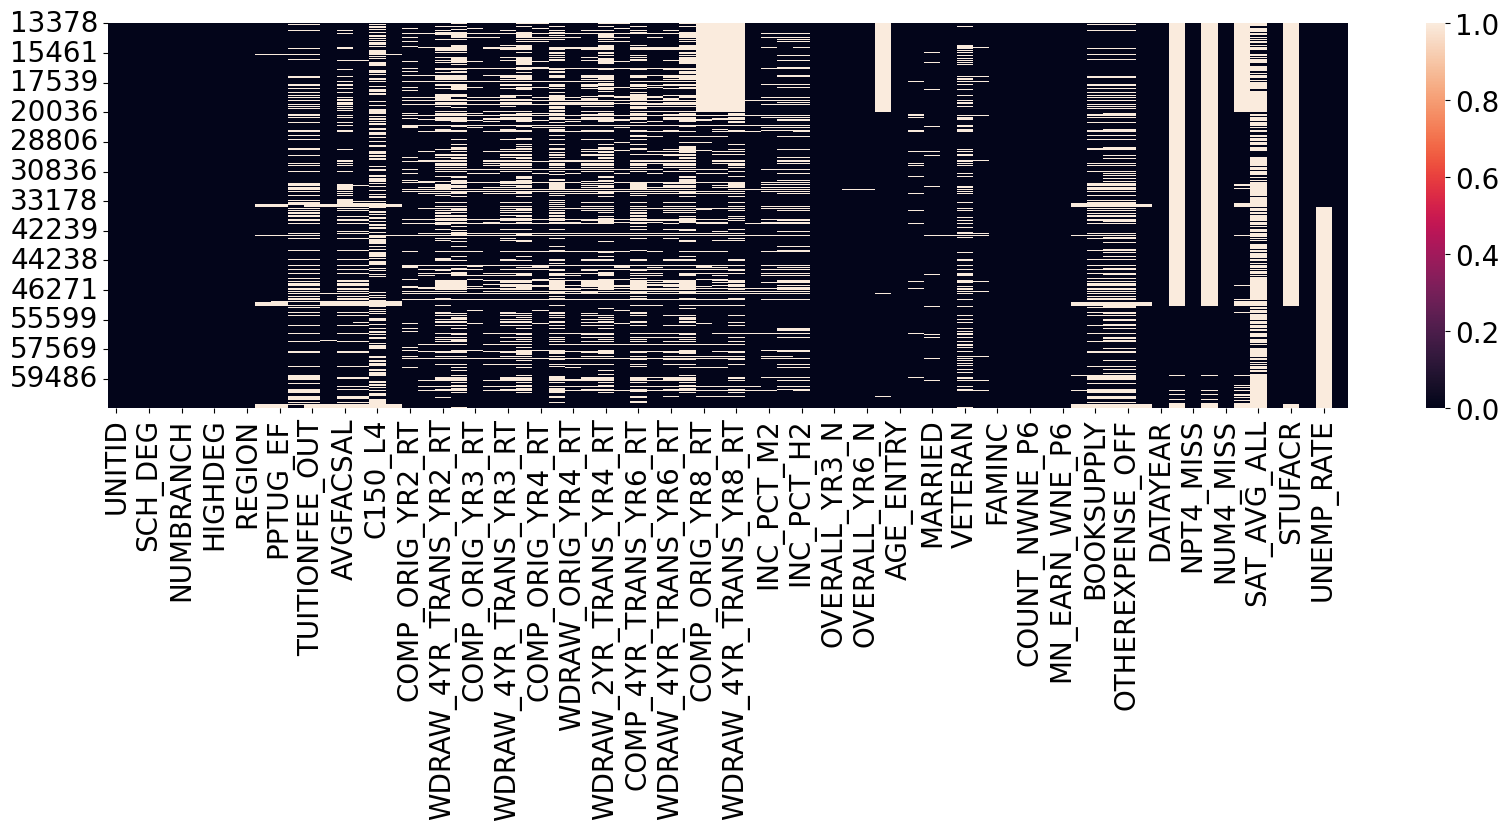

In [178]:
plt.figure(figsize=(20,5))
sns.heatmap(data.isnull())
plt.show()

In [179]:
## Drop redeundant columns and irrelevant columns: PELL, FIRSTGEN, 
to_drop = "C150_L4"
to_drop_cols = to_drop.split()
data = data.drop(to_drop_cols,axis=1)
data.shape

(22122, 75)

In [180]:
## Analyse data dictionary on excel and determine the numeric columns
numeric = """NUMBRANCH
UGDS
PPTUG_EF
TUITIONFEE_IN
TUITIONFEE_OUT
INEXPFTE
AVGFACSAL
PFTFAC
UG25ABV
COMP_ORIG_YR2_RT
WDRAW_ORIG_YR2_RT
WDRAW_4YR_TRANS_YR2_RT
WDRAW_2YR_TRANS_YR2_RT
COMP_ORIG_YR3_RT
WDRAW_ORIG_YR3_RT
WDRAW_4YR_TRANS_YR3_RT
WDRAW_2YR_TRANS_YR3_RT
COMP_ORIG_YR4_RT
COMP_4YR_TRANS_YR4_RT
WDRAW_ORIG_YR4_RT
WDRAW_4YR_TRANS_YR4_RT
WDRAW_2YR_TRANS_YR4_RT
COMP_ORIG_YR6_RT
COMP_4YR_TRANS_YR6_RT
WDRAW_ORIG_YR6_RT
WDRAW_4YR_TRANS_YR6_RT
WDRAW_2YR_TRANS_YR6_RT
COMP_ORIG_YR8_RT
WDRAW_ORIG_YR8_RT
WDRAW_4YR_TRANS_YR8_RT
INC_PCT_M1
INC_PCT_M2
INC_PCT_H1
INC_PCT_H2
OVERALL_YR2_N
OVERALL_YR3_N
OVERALL_YR4_N
OVERALL_YR6_N
OVERALL_YR8_N
FEMALE
MARRIED
DEPENDENT
VETERAN
FIRST_GEN
FAMINC
MD_FAMINC
COUNT_NWNE_P6
COUNT_WNE_P6
MN_EARN_WNE_P6
OPENADMP
BOOKSUPPLY
ROOMBOARD_OFF
OTHEREXPENSE_OFF
ADMCON7
NPT4_CONS
NUM4_CONS
RET_CONS
SAT_AVG_ALL
STUFACR
UNEMP_RATE"""
numeric_cols = numeric.split()
data[numeric_cols] = data[numeric_cols].astype("float64")
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

In [181]:
boolean = """MAIN
NPT4_MISS
NUM4_MISS
SAT_MISS
STUFACR_MISS
UNEMP_MISS
"""
bool_cols = boolean.split()
data[bool_cols] = data[bool_cols].astype("float64")
data[bool_cols] = data[bool_cols].fillna(0)

In [182]:
one_hot = "REGION"
one_hot_cols = one_hot.split()

In [183]:
ordinal = """SCH_DEG
PREDDEG
HIGHDEG
CONTROL
AGE_ENTRY
DATAYEAR"""
ordinal_cols = ordinal.split()
data[ordinal_cols] = data[ordinal_cols].astype("float64")
data[ordinal_cols] = data[ordinal_cols].fillna(data[ordinal_cols].mode())

In [184]:
identifiers = "UNITID INSTNM"
identifier_cols = identifiers.split()

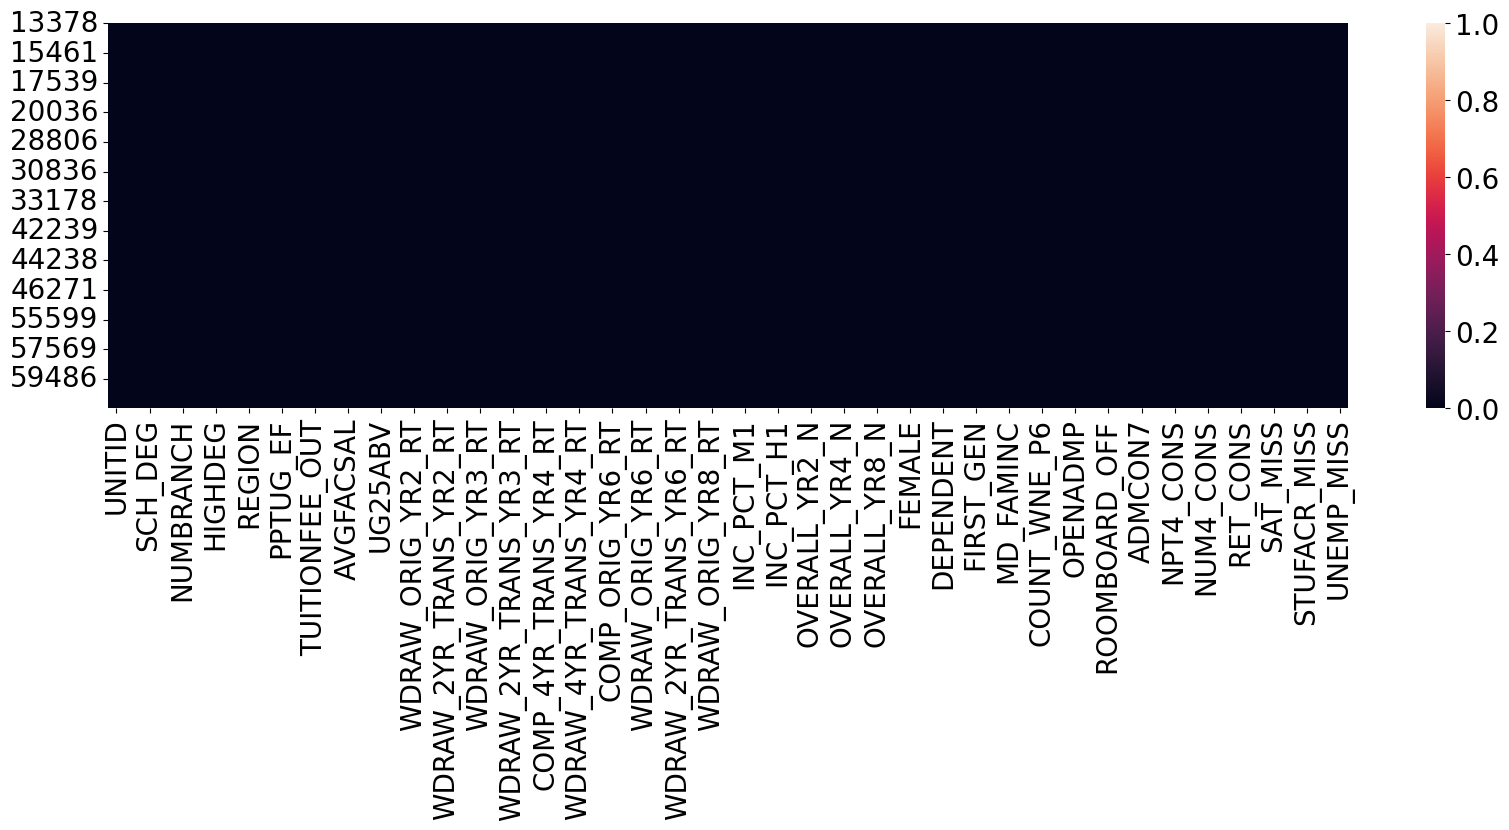

In [185]:
plt.figure(figsize=(20,5))
sns.heatmap(data.isnull())
plt.show()

In [189]:
data = data.drop(['AGE_ENTRY'],axis=1)
data.shape

(22122, 74)

In [190]:
data.to_csv("/kaggle/working/CleanedConsolidatedData.csv")

## Base Model: PCA and Regression

In [191]:
data = pd.read_csv("/kaggle/working/CleanedConsolidatedData.csv")
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,UNITID,INSTNM,SCH_DEG,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,REGION,UGDS,PPTUG_EF,TUITIONFEE_IN,TUITIONFEE_OUT,INEXPFTE,AVGFACSAL,PFTFAC,UG25ABV,COMP_ORIG_YR2_RT,WDRAW_ORIG_YR2_RT,WDRAW_4YR_TRANS_YR2_RT,WDRAW_2YR_TRANS_YR2_RT,COMP_ORIG_YR3_RT,WDRAW_ORIG_YR3_RT,WDRAW_4YR_TRANS_YR3_RT,WDRAW_2YR_TRANS_YR3_RT,COMP_ORIG_YR4_RT,COMP_4YR_TRANS_YR4_RT,WDRAW_ORIG_YR4_RT,WDRAW_4YR_TRANS_YR4_RT,WDRAW_2YR_TRANS_YR4_RT,COMP_ORIG_YR6_RT,COMP_4YR_TRANS_YR6_RT,WDRAW_ORIG_YR6_RT,WDRAW_4YR_TRANS_YR6_RT,WDRAW_2YR_TRANS_YR6_RT,COMP_ORIG_YR8_RT,WDRAW_ORIG_YR8_RT,WDRAW_4YR_TRANS_YR8_RT,INC_PCT_M1,INC_PCT_M2,INC_PCT_H1,INC_PCT_H2,OVERALL_YR2_N,OVERALL_YR3_N,OVERALL_YR4_N,OVERALL_YR6_N,OVERALL_YR8_N,FEMALE,MARRIED,DEPENDENT,VETERAN,FIRST_GEN,FAMINC,MD_FAMINC,COUNT_NWNE_P6,COUNT_WNE_P6,MN_EARN_WNE_P6,OPENADMP,BOOKSUPPLY,ROOMBOARD_OFF,OTHEREXPENSE_OFF,ADMCON7,DATAYEAR,NPT4_CONS,NPT4_MISS,NUM4_CONS,NUM4_MISS,RET_CONS,SAT_AVG_ALL,SAT_MISS,STUFACR,STUFACR_MISS,UNEMP_RATE,UNEMP_MISS
0,100654,Alabama A & M University,3.0,1.0,1.0,3.0,4.0,1.0,5,5292.0,0.0669,3352.0,6184.0,3470.0,4991.0,0.7786,0.1408,0.035195,0.277735,0.055853,0.026779,0.110561,0.267327,0.069307,0.041254,0.202317,0.023166,0.276448,0.098842,0.044788,0.338362,0.064655,0.261853,0.094828,0.029095,0.3979,0.223611,0.091886,0.179595,0.138714,0.092243,0.074773,1307.0,1212.0,1295.0,928.0,1262.031309,0.522013,0.041230,0.807128,0.015024,0.405545,30708.934312,21118.5,77.0,905.0,30300.0,2.0,900.0,4500.0,2300.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,850.000000,0.0,17.920043,1.0,4.91,0.0
1,100663,University of Alabama at Birmingham,3.0,1.0,1.0,3.0,4.0,1.0,5,10381.0,0.2696,4274.0,9494.0,14509.0,6734.0,0.8990,0.2879,0.052300,0.273123,0.035351,0.015496,0.375320,0.221198,0.031234,0.009217,0.365840,0.025930,0.293123,0.046787,0.018038,0.310146,0.059623,0.305439,0.071653,0.013075,0.3979,0.223611,0.091886,0.160661,0.152499,0.120446,0.116663,2065.0,1953.0,1774.0,1912.0,1262.031309,0.649015,0.123432,0.635676,0.027872,0.395604,36616.418873,25200.0,230.0,2349.0,37500.0,2.0,900.0,8823.0,3375.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,1010.000000,0.0,17.920043,1.0,3.57,0.0
2,100706,University of Alabama in Huntsville,3.0,1.0,1.0,3.0,4.0,1.0,5,4966.0,0.2424,4126.0,8702.0,5926.0,6257.0,0.5884,0.2830,0.084650,0.229120,0.045147,0.013544,0.168979,0.266078,0.054224,0.026482,0.228172,0.044237,0.298021,0.067520,0.029104,0.305981,0.061196,0.283727,0.118220,0.034771,0.3979,0.223611,0.091886,0.154124,0.167010,0.152577,0.130928,886.0,793.0,859.0,719.0,1262.031309,0.558763,0.182474,0.618041,0.034536,0.388951,41030.082474,30624.0,75.0,841.0,40600.0,2.0,720.0,6380.0,2280.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,1130.000000,0.0,17.920043,1.0,3.58,0.0
3,100724,Alabama State University,3.0,1.0,1.0,3.0,4.0,1.0,5,4941.0,0.1407,3600.0,7200.0,3774.0,5017.0,0.5690,0.1349,0.030162,0.295824,0.063805,0.030742,0.111984,0.280943,0.094303,0.038638,0.137657,0.023163,0.321641,0.105890,0.048974,0.207105,0.040816,0.345427,0.144369,0.042328,0.3979,0.223611,0.091886,0.189034,0.123599,0.072402,0.038473,1724.0,1527.0,1511.0,1323.0,1262.031309,0.555286,0.033323,0.828537,0.015450,0.443433,24636.551045,18597.0,166.0,1287.0,25300.0,2.0,800.0,5625.0,2820.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,1051.934851,1.0,17.920043,1.0,4.98,0.0
4,100751,The University of Alabama,3.0,1.0,1.0,3.0,4.0,1.0,5,15548.0,0.0902,4134.0,11294.0,6358.0,6551.0,0.8269,0.1130,0.092308,0.152991,0.026068,0.013675,0.268154,0.178517,0.046520,0.023449,0.434199,0.030176,0.201593,0.059095,0.018860,0.409828,0.071253,0.297789,0.081572,0.018673,0.3979,0.223611,0.091886,0.129356,0.157852,0.168102,0.234932,2340.0,2644.0,2386.0,2035.0,1262.031309,0.554121,0.061501,0.825953,0.019475,0.321429,53822.031980,41883.5,143.0,2337.0,37900.0,2.0,800.0,7102.0,2722.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,1090.000000,0.0,17.920043,1.0,3.40,0.0


In [193]:
y = data['MN_EARN_WNE_P6']
X = data.drop(['UNITID', 'INSTNM','MN_EARN_WNE_P6','REGION'],axis=1)
print(X.shape,y.shape)

(22122, 70) (22122,)


In [194]:
## Feature scaling – Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17697, 70) (4425, 70) (17697,) (4425,)


In [196]:
pca = PCA(n_components = 70)
pca.fit(X_scaled)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print(f"50% Explained Vairance: {len(cumulative_variance_ratio[cumulative_variance_ratio<0.5])}")
print(f"60% Explained Vairance: {len(cumulative_variance_ratio[cumulative_variance_ratio<0.6])}")
print(f"70% Explained Vairance: {len(cumulative_variance_ratio[cumulative_variance_ratio<0.7])}")
print(f"80% Explained Vairance: {len(cumulative_variance_ratio[cumulative_variance_ratio<0.8])}")
print(f"90% Explained Vairance: {len(cumulative_variance_ratio[cumulative_variance_ratio<0.9])}")
print(f"95% Explained Vairance: {len(cumulative_variance_ratio[cumulative_variance_ratio<0.95])}")
print(f"99% Explained Vairance: {len(cumulative_variance_ratio[cumulative_variance_ratio<0.99])}")

50% Explained Vairance: 4
60% Explained Vairance: 7
70% Explained Vairance: 11
80% Explained Vairance: 18
90% Explained Vairance: 29
95% Explained Vairance: 39
99% Explained Vairance: 53


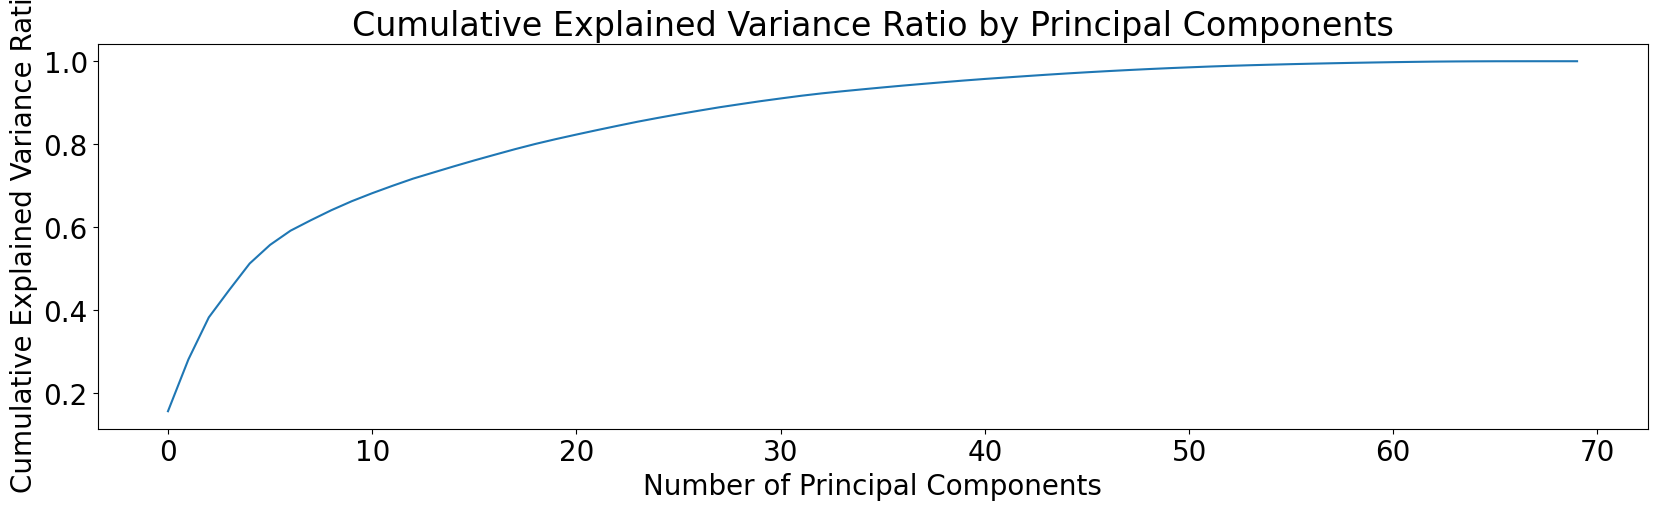

In [197]:
plt.figure(figsize=(20,5))
plt.plot(cumulative_variance_ratio)

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')

plt.show()

In [200]:
parameters = {'pca__n_components':[11,18,29,39,53,70]}
pipe = make_pipeline(PCA(), LinearRegression())

reg = GridSearchCV(pipe, parameters, cv=10, scoring='neg_mean_squared_error')
reg.fit(X_train, y_train)
print(np.sqrt(-1*reg.best_score_), reg.best_params_)

6821.9736897146 {'pca__n_components': 70}


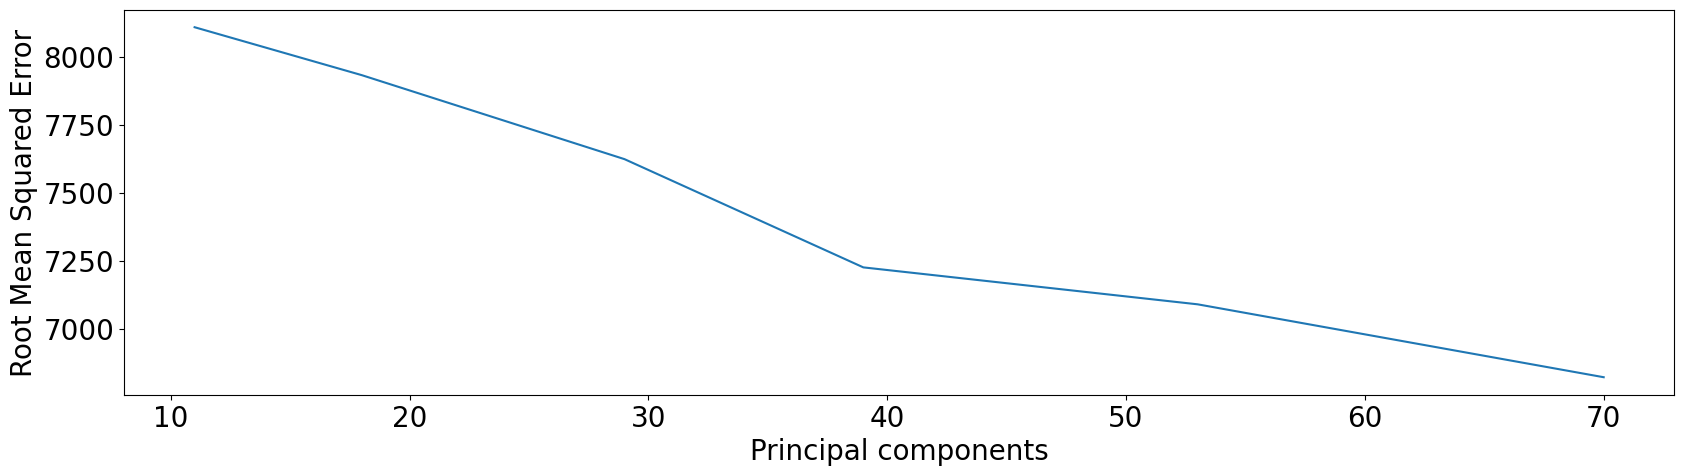

In [201]:
plt.figure(figsize=(20,5))
plt.plot(reg.cv_results_['param_pca__n_components'].data, np.sqrt(-1 * reg.cv_results_['mean_test_score']))
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Principal components")
plt.show()

In [202]:
pipe = make_pipeline(PCA(n_components=53), LinearRegression())
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred,y_test)))

6478.898065078076


## Model 2: Reduce Dimensions based on Feature Predictive Power

In [205]:
data = pd.read_csv("/kaggle/working/CleanedConsolidatedData.csv")
data = data.drop(['Unnamed: 0','UNITID', 'INSTNM'],axis=1)
data.head()

,SCH_DEG,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,REGION,UGDS,PPTUG_EF,TUITIONFEE_IN,TUITIONFEE_OUT,INEXPFTE,AVGFACSAL,PFTFAC,UG25ABV,COMP_ORIG_YR2_RT,WDRAW_ORIG_YR2_RT,WDRAW_4YR_TRANS_YR2_RT,WDRAW_2YR_TRANS_YR2_RT,COMP_ORIG_YR3_RT,WDRAW_ORIG_YR3_RT,WDRAW_4YR_TRANS_YR3_RT,WDRAW_2YR_TRANS_YR3_RT,COMP_ORIG_YR4_RT,COMP_4YR_TRANS_YR4_RT,WDRAW_ORIG_YR4_RT,WDRAW_4YR_TRANS_YR4_RT,WDRAW_2YR_TRANS_YR4_RT,COMP_ORIG_YR6_RT,COMP_4YR_TRANS_YR6_RT,WDRAW_ORIG_YR6_RT,WDRAW_4YR_TRANS_YR6_RT,WDRAW_2YR_TRANS_YR6_RT,COMP_ORIG_YR8_RT,WDRAW_ORIG_YR8_RT,WDRAW_4YR_TRANS_YR8_RT,INC_PCT_M1,INC_PCT_M2,INC_PCT_H1,INC_PCT_H2,OVERALL_YR2_N,OVERALL_YR3_N,OVERALL_YR4_N,OVERALL_YR6_N,OVERALL_YR8_N,FEMALE,MARRIED,DEPENDENT,VETERAN,FIRST_GEN,FAMINC,MD_FAMINC,COUNT_NWNE_P6,COUNT_WNE_P6,MN_EARN_WNE_P6,OPENADMP,BOOKSUPPLY,ROOMBOARD_OFF,OTHEREXPENSE_OFF,ADMCON7,DATAYEAR,NPT4_CONS,NPT4_MISS,NUM4_CONS,NUM4_MISS,RET_CONS,SAT_AVG_ALL,SAT_MISS,STUFACR,STUFACR_MISS,UNEMP_RATE,UNEMP_MISS
0,3.0,1.0,1.0,3.0,4.0,1.0,5,5292.0,0.0669,3352.0,6184.0,3470.0,4991.0,0.7786,0.1408,0.035195,0.277735,0.055853,0.026779,0.110561,0.267327,0.069307,0.041254,0.202317,0.023166,0.276448,0.098842,0.044788,0.338362,0.064655,0.261853,0.094828,0.029095,0.3979,0.223611,0.091886,0.179595,0.138714,0.092243,0.074773,1307.0,1212.0,1295.0,928.0,1262.031309,0.522013,0.041230,0.807128,0.015024,0.405545,30708.934312,21118.5,77.0,905.0,30300.0,2.0,900.0,4500.0,2300.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,850.000000,0.0,17.920043,1.0,4.91,0.0
1,3.0,1.0,1.0,3.0,4.0,1.0,5,10381.0,0.2696,4274.0,9494.0,14509.0,6734.0,0.8990,0.2879,0.052300,0.273123,0.035351,0.015496,0.375320,0.221198,0.031234,0.009217,0.365840,0.025930,0.293123,0.046787,0.018038,0.310146,0.059623,0.305439,0.071653,0.013075,0.3979,0.223611,0.091886,0.160661,0.152499,0.120446,0.116663,2065.0,1953.0,1774.0,1912.0,1262.031309,0.649015,0.123432,0.635676,0.027872,0.395604,36616.418873,25200.0,230.0,2349.0,37500.0,2.0,900.0,8823.0,3375.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,1010.000000,0.0,17.920043,1.0,3.57,0.0
2,3.0,1.0,1.0,3.0,4.0,1.0,5,4966.0,0.2424,4126.0,8702.0,5926.0,6257.0,0.5884,0.2830,0.084650,0.229120,0.045147,0.013544,0.168979,0.266078,0.054224,0.026482,0.228172,0.044237,0.298021,0.067520,0.029104,0.305981,0.061196,0.283727,0.118220,0.034771,0.3979,0.223611,0.091886,0.154124,0.167010,0.152577,0.130928,886.0,793.0,859.0,719.0,1262.031309,0.558763,0.182474,0.618041,0.034536,0.388951,41030.082474,30624.0,75.0,841.0,40600.0,2.0,720.0,6380.0,2280.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,1130.000000,0.0,17.920043,1.0,3.58,0.0
3,3.0,1.0,1.0,3.0,4.0,1.0,5,4941.0,0.1407,3600.0,7200.0,3774.0,5017.0,0.5690,0.1349,0.030162,0.295824,0.063805,0.030742,0.111984,0.280943,0.094303,0.038638,0.137657,0.023163,0.321641,0.105890,0.048974,0.207105,0.040816,0.345427,0.144369,0.042328,0.3979,0.223611,0.091886,0.189034,0.123599,0.072402,0.038473,1724.0,1527.0,1511.0,1323.0,1262.031309,0.555286,0.033323,0.828537,0.015450,0.443433,24636.551045,18597.0,166.0,1287.0,25300.0,2.0,800.0,5625.0,2820.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,1051.934851,1.0,17.920043,1.0,4.98,0.0
4,3.0,1.0,1.0,3.0,4.0,1.0,5,15548.0,0.0902,4134.0,11294.0,6358.0,6551.0,0.8269,0.1130,0.092308,0.152991,0.026068,0.013675,0.268154,0.178517,0.046520,0.023449,0.434199,0.030176,0.201593,0.059095,0.018860,0.409828,0.071253,0.297789,0.081572,0.018673,0.3979,0.223611,0.091886,0.129356,0.157852,0.168102,0.234932,2340.0,2644.0,2386.0,2035.0,1262.031309,0.554121,0.061501,0.825953,0.019475,0.321429,53822.031980,41883.5,143.0,2337.0,37900.0,2.0,800.0,7102.0,2722.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,1090.000000,0.0,17.920043,1.0,3.40,0.0


In [206]:
## Find that correlate the most with the target variable
y_corr = data.corr().abs()[['MN_EARN_WNE_P6']]
print(f"Number of features with linear correlation above 50%: {y_corr[y_corr>0.5].count()}")

data_sq = data**2
data_sq['MN_EARN_WNE_P6'] = data[['MN_EARN_WNE_P6']]
y_sq_corr = data_sq.corr().abs()[['MN_EARN_WNE_P6']]
print(f"Number of features with quadratic correlation above 50%: {y_sq_corr[y_sq_corr>0.5].count()}")

data_log = np.log(data)
data_log['MN_EARN_WNE_P6'] = data[['MN_EARN_WNE_P6']]
y_log_corr = data_log.corr().abs()[['MN_EARN_WNE_P6']]
print(f"Number of features with logarithmic correlation above 50%: {y_log_corr[y_log_corr>0.5].count()}")

Number of features with linear correlation above 50%: MN_EARN_WNE_P6    4
dtype: int64
Number of features with quadratic correlation above 50%: MN_EARN_WNE_P6    4
dtype: int64
Number of features with logarithmic correlation above 50%: MN_EARN_WNE_P6    6
dtype: int64


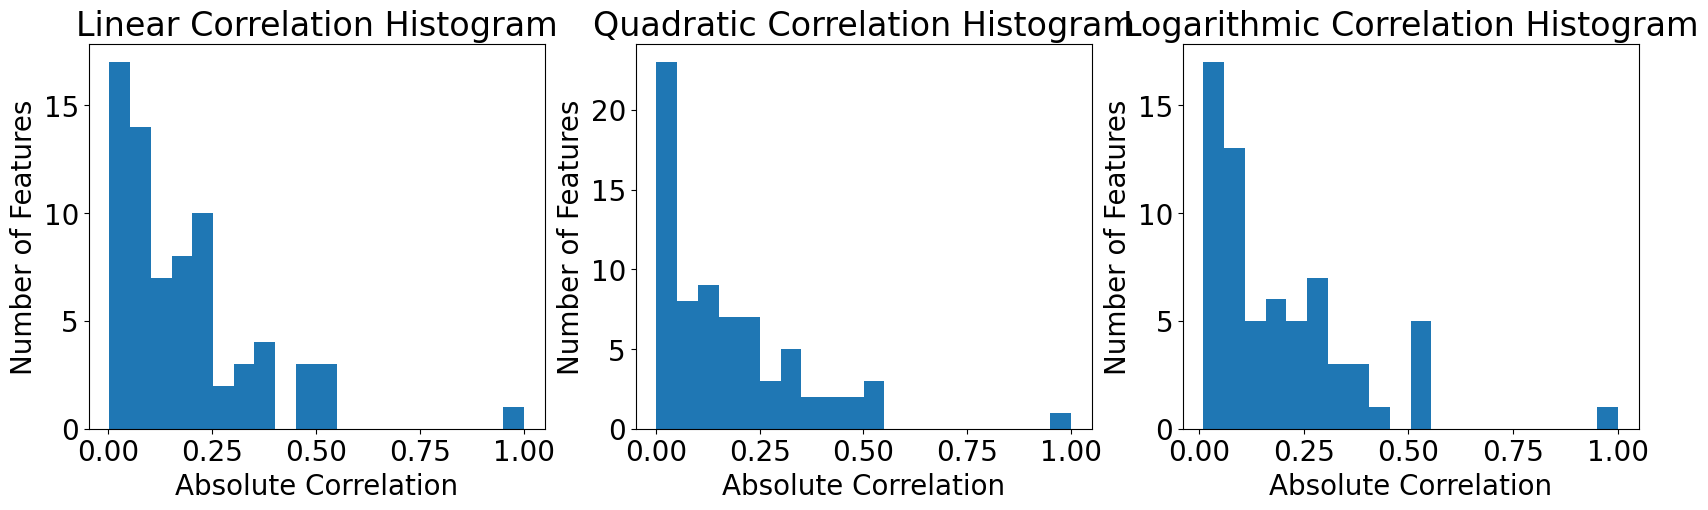

In [207]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.hist(y_corr,bins=20)
plt.ylabel("Number of Features")
plt.xlabel("Absolute Correlation")
plt.title("Linear Correlation Histogram")
      
plt.subplot(1,3,2)
plt.hist(y_sq_corr,bins=20)
plt.ylabel("Number of Features")
plt.xlabel("Absolute Correlation")
plt.title("Quadratic Correlation Histogram")
      
plt.subplot(1,3,3)
plt.hist(y_log_corr,bins=20)
plt.ylabel("Number of Features")
plt.xlabel("Absolute Correlation")
plt.title("Logarithmic Correlation Histogram")

plt.show()

In [208]:
print(y_corr[y_corr>0.7].count())
print(y_sq_corr[y_sq_corr>0.7].count())
print(y_log_corr[y_log_corr>0.7].count())

MN_EARN_WNE_P6    1
dtype: int64
MN_EARN_WNE_P6    1
dtype: int64
MN_EARN_WNE_P6    1
dtype: int64


In [ ]:
## Remove Correlated Features

In [ ]:
## Fit a Final Regression

## Model 3: Choose important features using a Random Forest

In [261]:
data = pd.read_csv("/kaggle/working/CleanedConsolidatedData.csv")
data = data.drop(['Unnamed: 0','UNITID', 'INSTNM','REGION'],axis=1)
data.head()

,SCH_DEG,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,UGDS,PPTUG_EF,TUITIONFEE_IN,TUITIONFEE_OUT,INEXPFTE,AVGFACSAL,PFTFAC,UG25ABV,COMP_ORIG_YR2_RT,WDRAW_ORIG_YR2_RT,WDRAW_4YR_TRANS_YR2_RT,WDRAW_2YR_TRANS_YR2_RT,COMP_ORIG_YR3_RT,WDRAW_ORIG_YR3_RT,WDRAW_4YR_TRANS_YR3_RT,WDRAW_2YR_TRANS_YR3_RT,COMP_ORIG_YR4_RT,COMP_4YR_TRANS_YR4_RT,WDRAW_ORIG_YR4_RT,WDRAW_4YR_TRANS_YR4_RT,WDRAW_2YR_TRANS_YR4_RT,COMP_ORIG_YR6_RT,COMP_4YR_TRANS_YR6_RT,WDRAW_ORIG_YR6_RT,WDRAW_4YR_TRANS_YR6_RT,WDRAW_2YR_TRANS_YR6_RT,COMP_ORIG_YR8_RT,WDRAW_ORIG_YR8_RT,WDRAW_4YR_TRANS_YR8_RT,INC_PCT_M1,INC_PCT_M2,INC_PCT_H1,INC_PCT_H2,OVERALL_YR2_N,OVERALL_YR3_N,OVERALL_YR4_N,OVERALL_YR6_N,OVERALL_YR8_N,FEMALE,MARRIED,DEPENDENT,VETERAN,FIRST_GEN,FAMINC,MD_FAMINC,COUNT_NWNE_P6,COUNT_WNE_P6,MN_EARN_WNE_P6,OPENADMP,BOOKSUPPLY,ROOMBOARD_OFF,OTHEREXPENSE_OFF,ADMCON7,DATAYEAR,NPT4_CONS,NPT4_MISS,NUM4_CONS,NUM4_MISS,RET_CONS,SAT_AVG_ALL,SAT_MISS,STUFACR,STUFACR_MISS,UNEMP_RATE,UNEMP_MISS
0,3.0,1.0,1.0,3.0,4.0,1.0,5292.0,0.0669,3352.0,6184.0,3470.0,4991.0,0.7786,0.1408,0.035195,0.277735,0.055853,0.026779,0.110561,0.267327,0.069307,0.041254,0.202317,0.023166,0.276448,0.098842,0.044788,0.338362,0.064655,0.261853,0.094828,0.029095,0.3979,0.223611,0.091886,0.179595,0.138714,0.092243,0.074773,1307.0,1212.0,1295.0,928.0,1262.031309,0.522013,0.041230,0.807128,0.015024,0.405545,30708.934312,21118.5,77.0,905.0,30300.0,2.0,900.0,4500.0,2300.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,850.000000,0.0,17.920043,1.0,4.91,0.0
1,3.0,1.0,1.0,3.0,4.0,1.0,10381.0,0.2696,4274.0,9494.0,14509.0,6734.0,0.8990,0.2879,0.052300,0.273123,0.035351,0.015496,0.375320,0.221198,0.031234,0.009217,0.365840,0.025930,0.293123,0.046787,0.018038,0.310146,0.059623,0.305439,0.071653,0.013075,0.3979,0.223611,0.091886,0.160661,0.152499,0.120446,0.116663,2065.0,1953.0,1774.0,1912.0,1262.031309,0.649015,0.123432,0.635676,0.027872,0.395604,36616.418873,25200.0,230.0,2349.0,37500.0,2.0,900.0,8823.0,3375.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,1010.000000,0.0,17.920043,1.0,3.57,0.0
2,3.0,1.0,1.0,3.0,4.0,1.0,4966.0,0.2424,4126.0,8702.0,5926.0,6257.0,0.5884,0.2830,0.084650,0.229120,0.045147,0.013544,0.168979,0.266078,0.054224,0.026482,0.228172,0.044237,0.298021,0.067520,0.029104,0.305981,0.061196,0.283727,0.118220,0.034771,0.3979,0.223611,0.091886,0.154124,0.167010,0.152577,0.130928,886.0,793.0,859.0,719.0,1262.031309,0.558763,0.182474,0.618041,0.034536,0.388951,41030.082474,30624.0,75.0,841.0,40600.0,2.0,720.0,6380.0,2280.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,1130.000000,0.0,17.920043,1.0,3.58,0.0
3,3.0,1.0,1.0,3.0,4.0,1.0,4941.0,0.1407,3600.0,7200.0,3774.0,5017.0,0.5690,0.1349,0.030162,0.295824,0.063805,0.030742,0.111984,0.280943,0.094303,0.038638,0.137657,0.023163,0.321641,0.105890,0.048974,0.207105,0.040816,0.345427,0.144369,0.042328,0.3979,0.223611,0.091886,0.189034,0.123599,0.072402,0.038473,1724.0,1527.0,1511.0,1323.0,1262.031309,0.555286,0.033323,0.828537,0.015450,0.443433,24636.551045,18597.0,166.0,1287.0,25300.0,2.0,800.0,5625.0,2820.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,1051.934851,1.0,17.920043,1.0,4.98,0.0
4,3.0,1.0,1.0,3.0,4.0,1.0,15548.0,0.0902,4134.0,11294.0,6358.0,6551.0,0.8269,0.1130,0.092308,0.152991,0.026068,0.013675,0.268154,0.178517,0.046520,0.023449,0.434199,0.030176,0.201593,0.059095,0.018860,0.409828,0.071253,0.297789,0.081572,0.018673,0.3979,0.223611,0.091886,0.129356,0.157852,0.168102,0.234932,2340.0,2644.0,2386.0,2035.0,1262.031309,0.554121,0.061501,0.825953,0.019475,0.321429,53822.031980,41883.5,143.0,2337.0,37900.0,2.0,800.0,7102.0,2722.0,1.0,2003.0,16679.01833,1.0,16679.01833,1.0,0.617163,1090.000000,0.0,17.920043,1.0,3.40,0.0


In [262]:
y = data['MN_EARN_WNE_P6']
X = data.drop(['MN_EARN_WNE_P6'], axis=1)
print(X.shape,y.shape)

(22122, 70) (22122,)


### Handle Pairwise Correlation

In [263]:
## Find pairwise correlation among features
corr = X.corr().abs()
corr.shape

(70, 70)

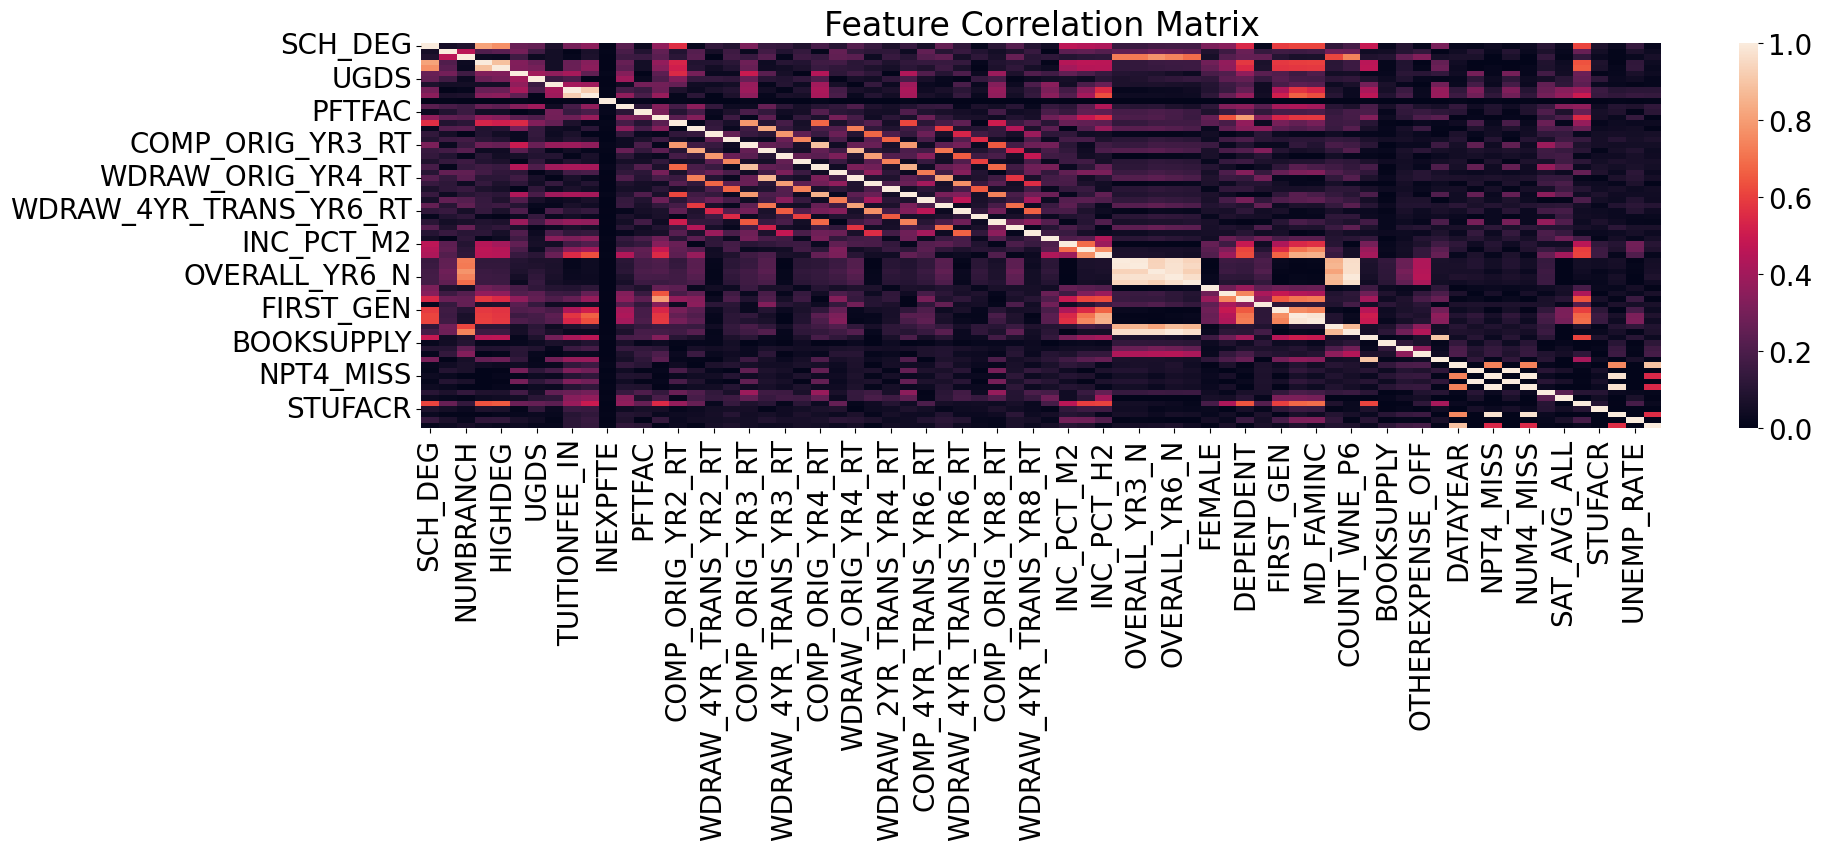

In [264]:
plt.figure(figsize=(20,5))
sns.heatmap(corr)
plt.axis()
plt.title('Feature Correlation Matrix')
plt.show()

In [265]:
thresh = 0.85
corr_to_drop = list()

for i in range(len(X.columns)):
    if i not in corr_to_drop:
        mask = corr[X.columns[i]] >= thresh
        correlated = list(corr[X.columns[i]][mask].keys())
        for j in correlated:
            if j != X.columns[i] and j not in corr_to_drop:
                corr_to_drop.append(j)
                
print(len(corr_to_drop),corr_to_drop)

26 ['HIGHDEG', 'PREDDEG', 'TUITIONFEE_OUT', 'TUITIONFEE_IN', 'COMP_ORIG_YR4_RT', 'WDRAW_ORIG_YR4_RT', 'COMP_ORIG_YR3_RT', 'WDRAW_ORIG_YR3_RT', 'OVERALL_YR3_N', 'OVERALL_YR4_N', 'OVERALL_YR6_N', 'OVERALL_YR8_N', 'COUNT_WNE_P6', 'OVERALL_YR2_N', 'COUNT_NWNE_P6', 'MD_FAMINC', 'FAMINC', 'ADMCON7', 'OPENADMP', 'UNEMP_MISS', 'NUM4_CONS', 'NUM4_MISS', 'STUFACR_MISS', 'NPT4_CONS', 'NPT4_MISS', 'DATAYEAR']


In [266]:
X = X.drop(corr_to_drop,axis=1)
print(X.shape)

(22122, 44)


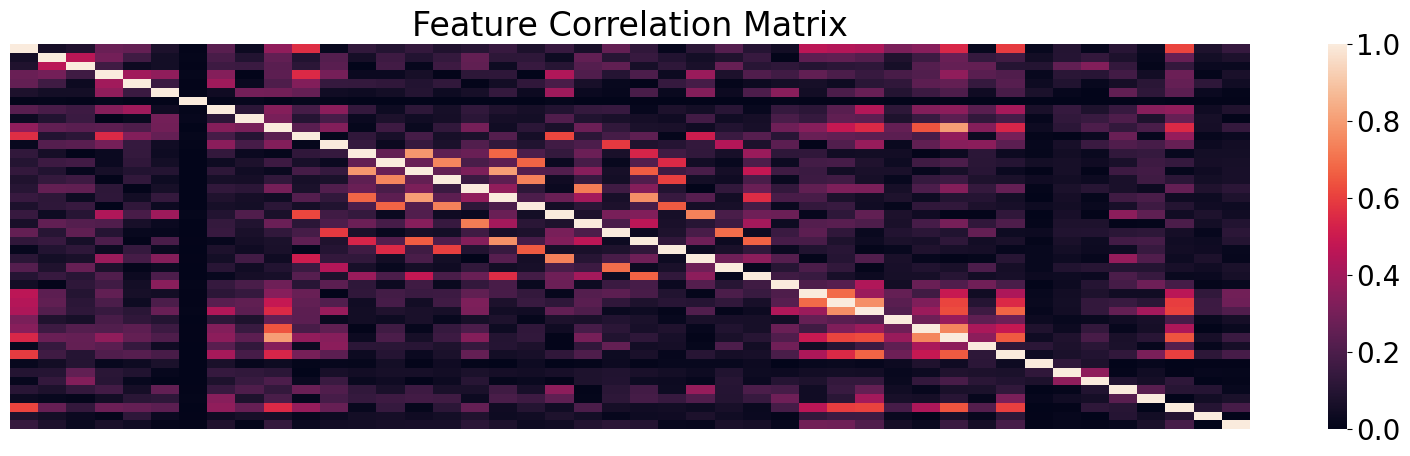

In [267]:
plt.figure(figsize=(20,5))
sns.heatmap(X.corr().abs())
plt.axis('off')
plt.title('Feature Correlation Matrix')
plt.show()

## Feature Selection

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17697, 44) (4425, 44) (17697,) (4425,)


In [250]:
## High compute cell: final result – -17396733.641652998 {'max_features': 0.5, 'n_estimators': 120}
parameters = {'n_estimators':[40,60,80,100,120],'max_features':[0.3,0.5,0.7,0.9,1]}
forest = RandomForestRegressor()

reg = GridSearchCV(forest, parameters, cv=10, scoring='neg_mean_squared_error')
reg.fit(X_train, y_train)
print(np.sqrt(-1*reg.best_score_), reg.best_params_)

KeyboardInterrupt: 

In [269]:
forest = RandomForestRegressor(max_features=0.9, n_estimators=100)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred,y_test)))

4245.473547522333


In [270]:
importances = pd.DataFrame()
importances['features'] = X.columns
importances['values'] = forest.feature_importances_
importances = importances.sort_values(by=['values'],ascending=False)
importances.head(20)

,features,values
0,SCH_DEG,0.259680
7,AVGFACSAL,0.096394
33,DEPENDENT,0.084153
27,INC_PCT_M1,0.070112
30,INC_PCT_H2,0.057408
6,INEXPFTE,0.054312
10,COMP_ORIG_YR2_RT,0.041809
31,FEMALE,0.041481
29,INC_PCT_H1,0.029711
4,UGDS,0.023523


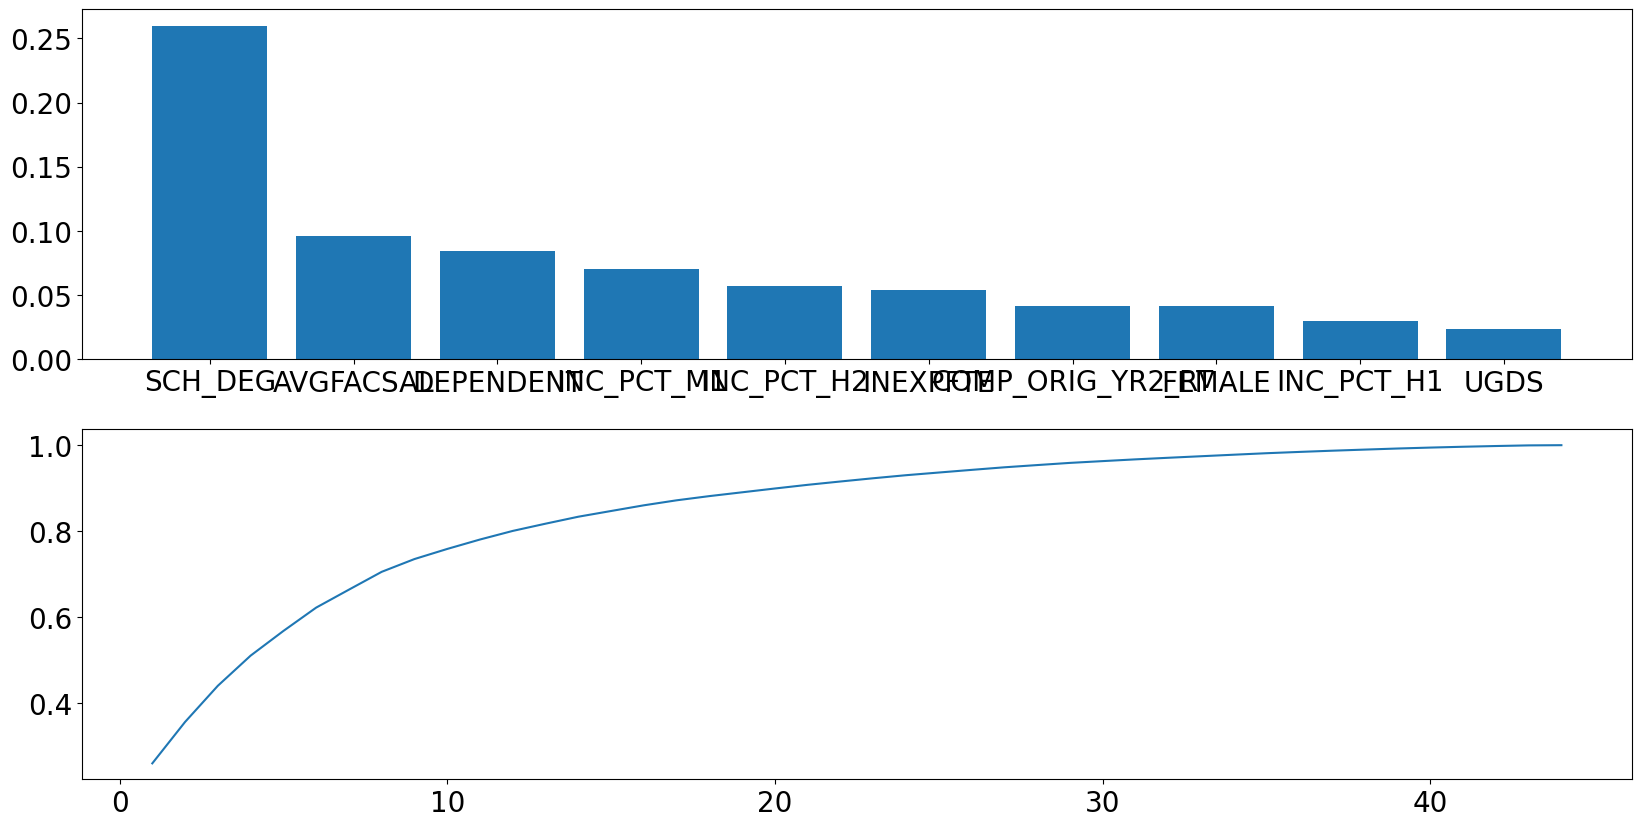

In [271]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.bar(importances['features'][:10],importances['values'][:10])

plt.subplot(2,1,2)
plt.plot(np.arange(1,len(importances['features'])+1),np.cumsum(importances['values']))

plt.show()

In [272]:
print(importances['values'][np.cumsum(importances['values'])<=0.99].count())
print(importances['values'][np.cumsum(importances['values'])<=0.95].count())
print(importances['values'][np.cumsum(importances['values'])<=0.9].count())
print(importances['values'][np.cumsum(importances['values'])<=0.8].count())

38
27
20
11


### Linear Regression
#### Focus on 11 features, 80% importance

In [273]:
X = data[importances['features'][np.cumsum(importances['values'])<=0.8]]
y = data['MN_EARN_WNE_P6']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2 , random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17697, 11) (4425, 11) (17697,) (4425,)


In [274]:
model = ElasticNet(alpha=1,l1_ratio=0.9)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred,y_test)))

7727.274515514872


In [275]:
## We do not get any model improvement by adding Polynomial Features, therefore, we focus on linear features during GridSearchCV
pipe = make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=2,l1_ratio=0.9))
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred,y_test)))

6731.0522607375415


In [276]:
parameters = {'alpha':[0,1,2,3,4],'l1_ratio':[0.6,0.7,0.8,0.9,1]}
elastnet = ElasticNet()

reg = GridSearchCV(elastnet, parameters, cv=10, scoring='neg_mean_squared_error')
reg.fit(X_train, y_train)
print(np.sqrt(-1*reg.best_score_), reg.best_params_)

8065.140334114111 {'alpha': 4, 'l1_ratio': 1}


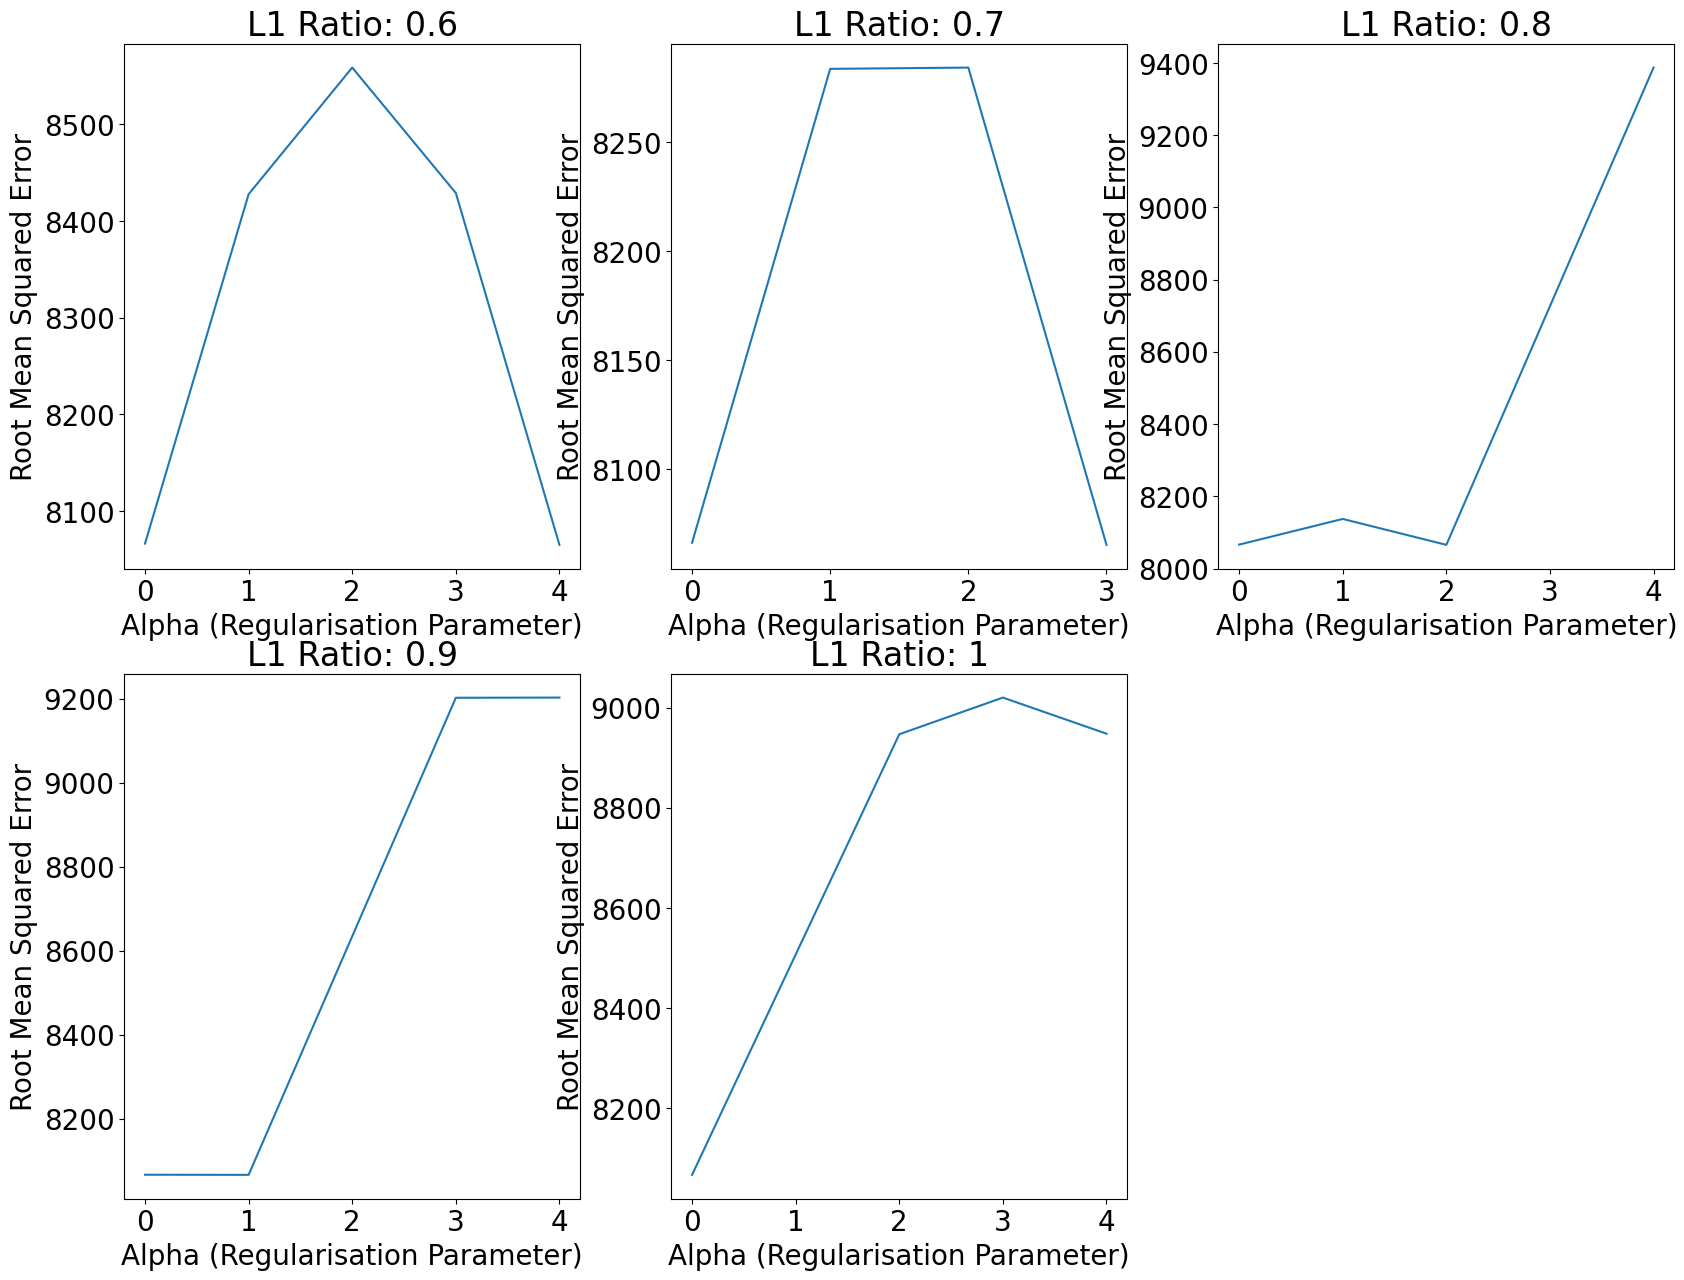

In [278]:
plt.figure(figsize=(20,15))

for i in range(len(reg.cv_results_['param_alpha'].data[::5])):
    plt.subplot(2,3,i+1)
    plt.plot(reg.cv_results_['param_alpha'].data[i::6],np.sqrt(-1 * reg.cv_results_['mean_test_score'][i::6]))
    plt.title(f"L1 Ratio: {reg.cv_results_['param_l1_ratio'].data[i::6][0]}")
    plt.xlabel('Alpha (Regularisation Parameter)')
    plt.ylabel('Root Mean Squared Error')

#### Focus on 20 Features, 90% importance

In [279]:
X = data[importances['features'][np.cumsum(importances['values'])<=0.9]]
y = data['MN_EARN_WNE_P6']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2 , random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17697, 20) (4425, 20) (17697,) (4425,)


In [283]:
model = ElasticNet(alpha=2,l1_ratio=0.9)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred,y_test)))

7456.935546751507


In [281]:
## We do not get any model improvement by adding Polynomial Features, therefore, we focus on linear features during GridSearchCV
pipe = make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=2,l1_ratio=0.9))
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred,y_test)))

7033.425461178166


In [282]:
parameters = {'alpha':[0,1,2,3,4],'l1_ratio':[0,0.3,0.5,0.7,0.9,1]}
elastnet = ElasticNet()

reg = GridSearchCV(elastnet, parameters, cv=10, scoring='neg_mean_squared_error')
reg.fit(X_train, y_train)
print(np.sqrt(-1*reg.best_score_), reg.best_params_)

7790.998062177581 {'alpha': 4, 'l1_ratio': 1}


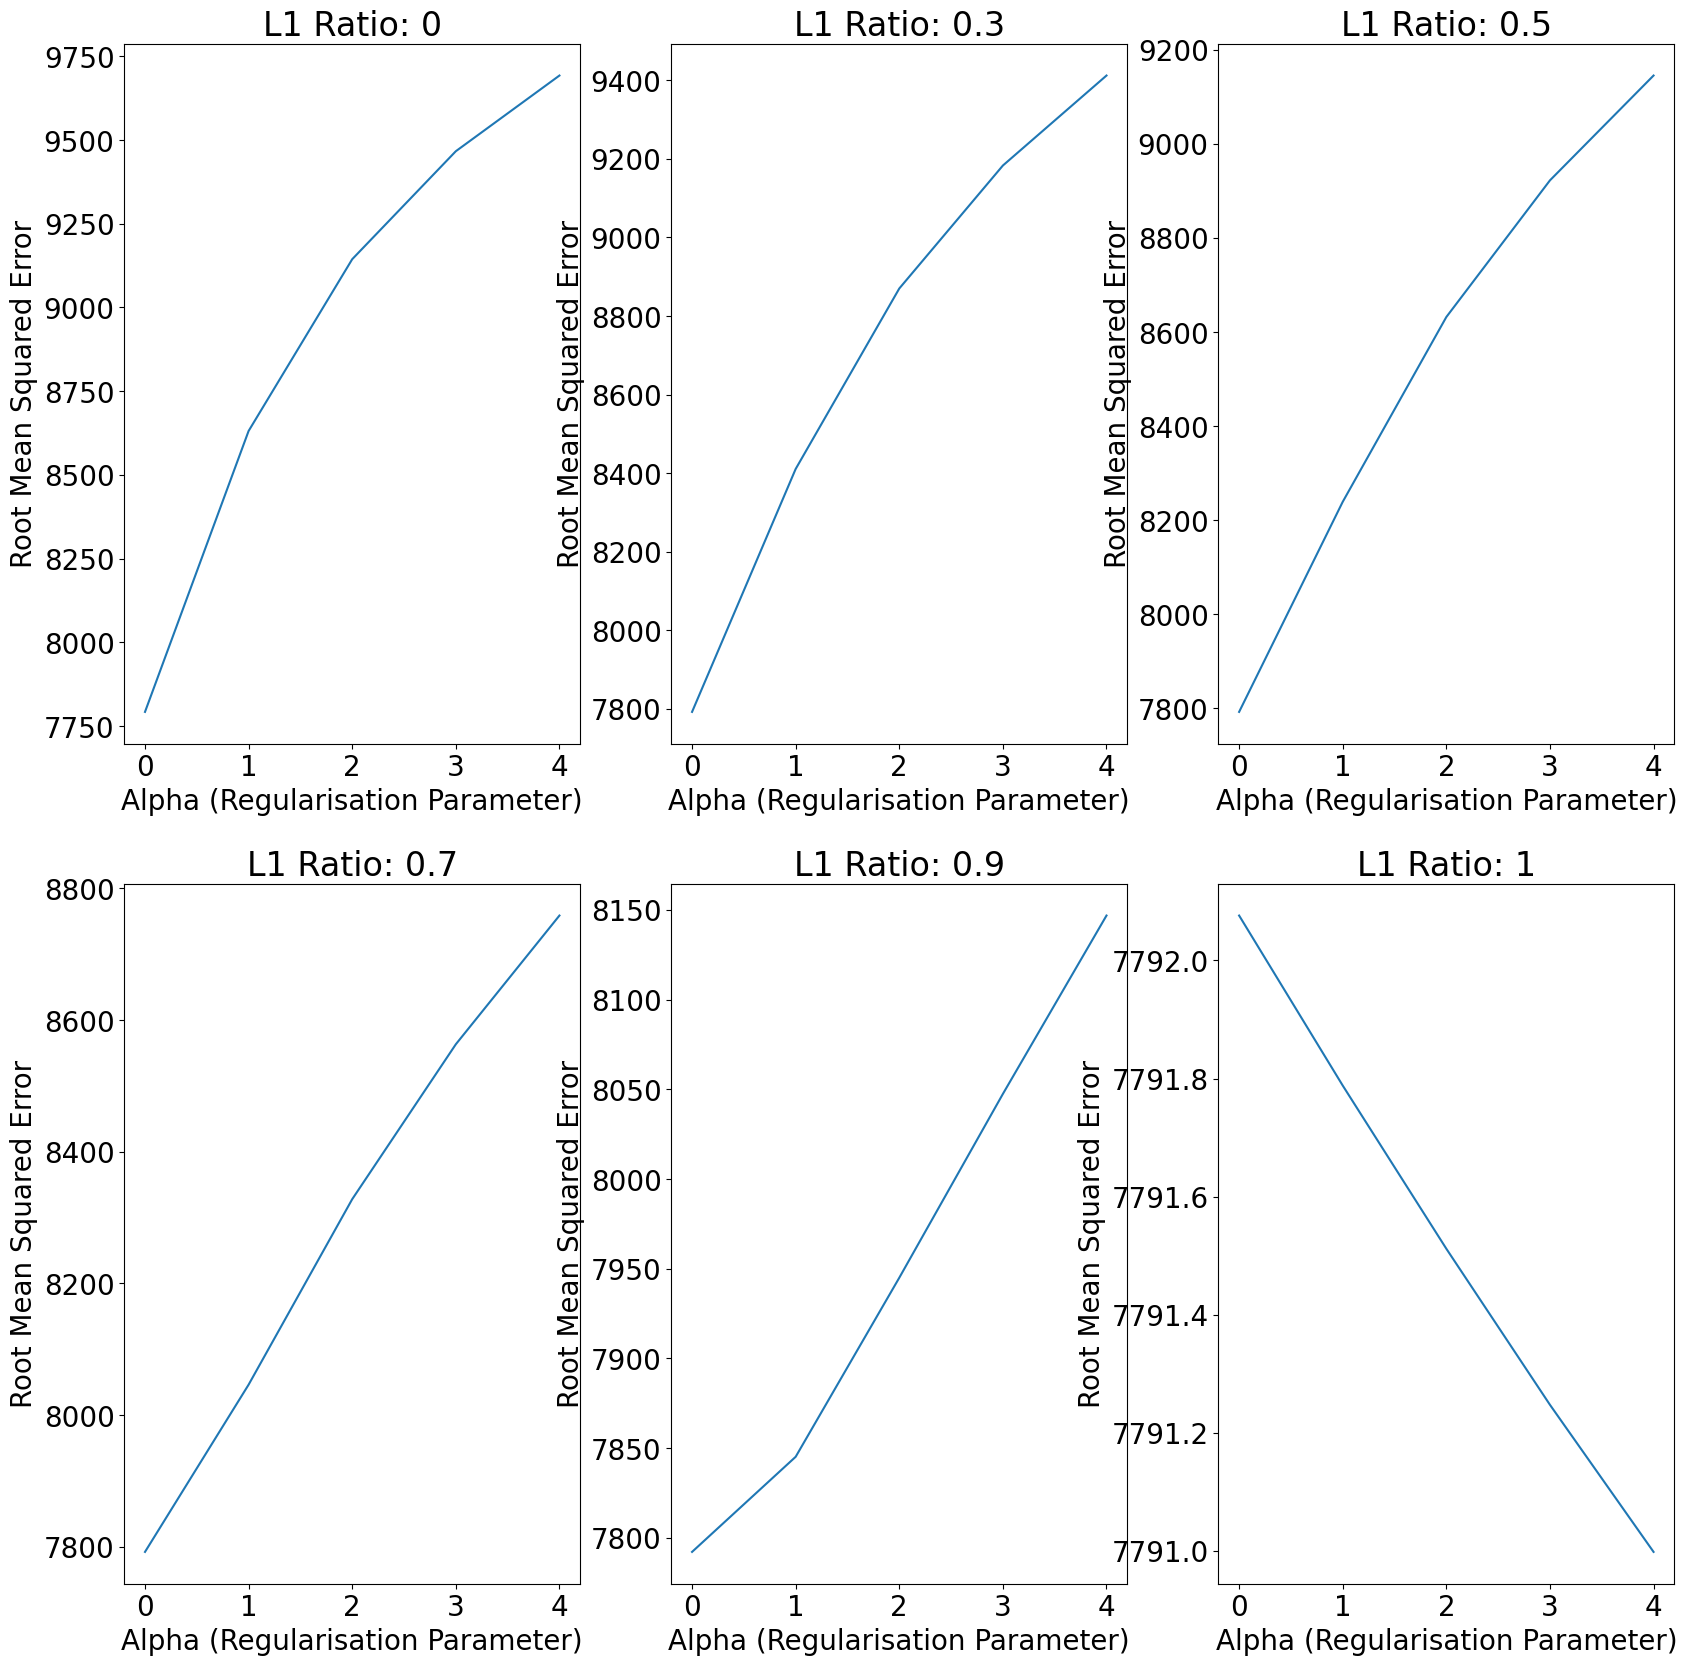

In [285]:
plt.figure(figsize=(20,20))

for i in range(len(reg.cv_results_['param_alpha'].data[::5])):
    plt.subplot(2,3,i+1)
    plt.plot(reg.cv_results_['param_alpha'].data[i::6],np.sqrt(-1 * reg.cv_results_['mean_test_score'][i::6]))
    plt.title(f"L1 Ratio: {reg.cv_results_['param_l1_ratio'].data[i::6][0]}")
    plt.xlabel('Alpha (Regularisation Parameter)')
    plt.ylabel('Root Mean Squared Error')

#### Focus on 27 features, 95% importance

In [286]:
X = data[importances['features'][np.cumsum(importances['values'])<=0.95]]
y = data['MN_EARN_WNE_P6']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2 , random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17697, 27) (4425, 27) (17697,) (4425,)


In [287]:
model = ElasticNet(alpha=2,l1_ratio=0.9)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred,y_test)))

7075.027709763208


In [288]:
## We do not get any model improvement by adding Polynomial Features, therefore, we focus on linear features during GridSearchCV
pipe = make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=2,l1_ratio=0.9))
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred,y_test)))

6465.236826708433


In [289]:
parameters = {'alpha':[0,1,2,3,4],'l1_ratio':[0,0.3,0.5,0.7,0.9,1]}
elastnet = ElasticNet()

reg = GridSearchCV(elastnet, parameters, cv=10, scoring='neg_mean_squared_error')
reg.fit(X_train, y_train)
print(np.sqrt(-1*reg.best_score_), reg.best_params_)

7481.75829777692 {'alpha': 4, 'l1_ratio': 1}


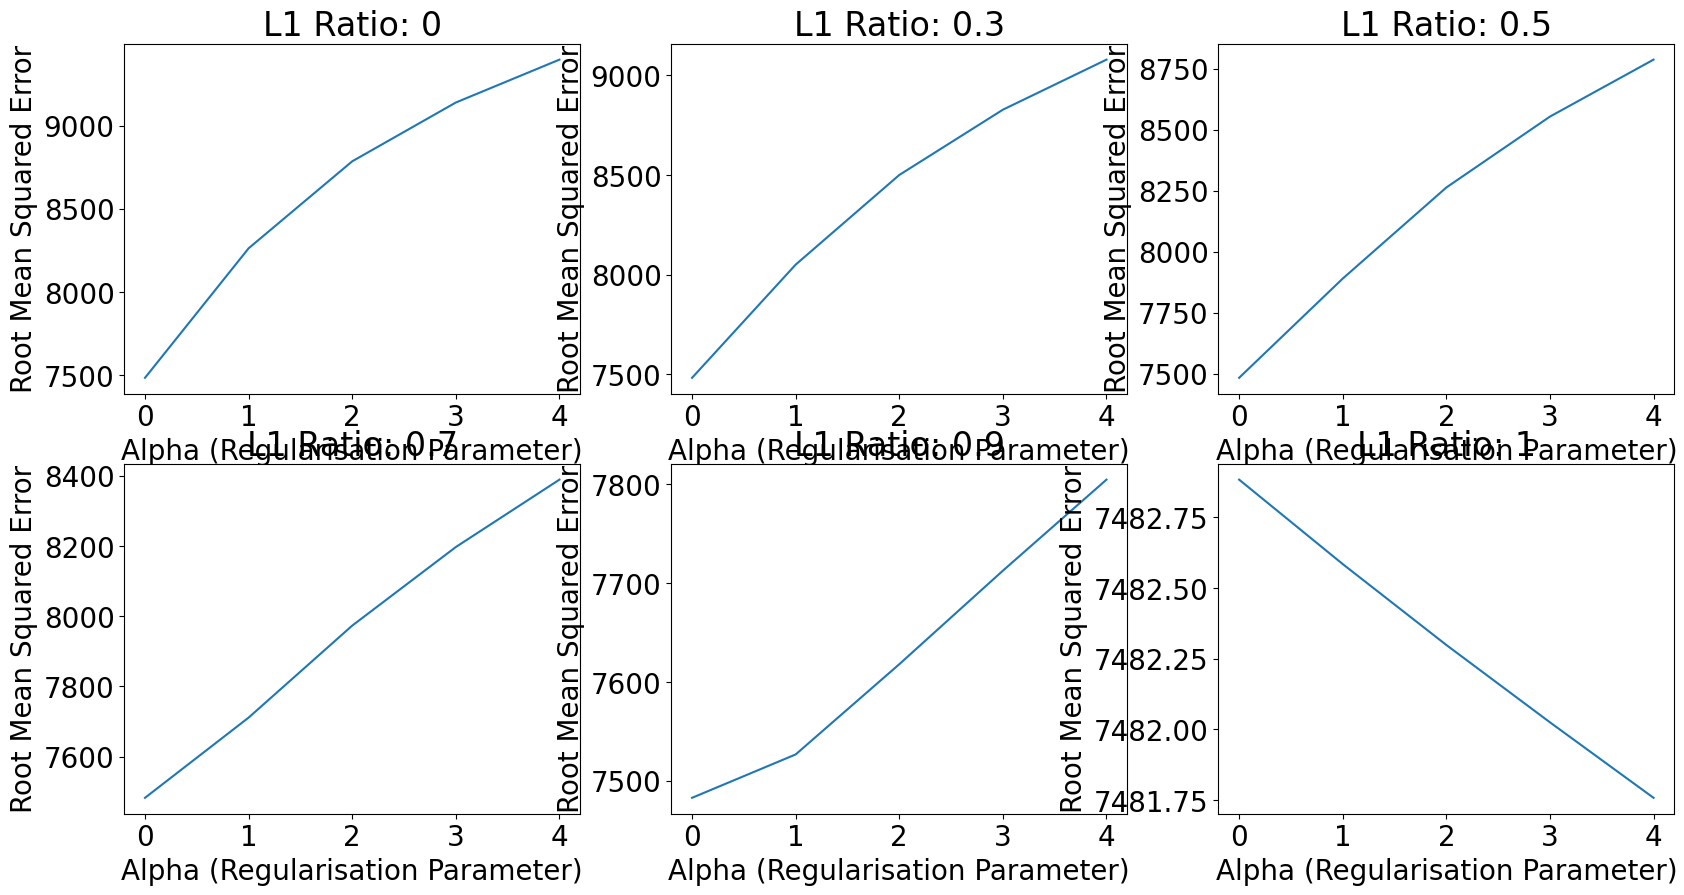

In [290]:
plt.figure(figsize=(20,10))

for i in range(len(reg.cv_results_['param_alpha'].data[::5])):
    plt.subplot(2,3,i+1)
    plt.plot(reg.cv_results_['param_alpha'].data[i::6],np.sqrt(-1 * reg.cv_results_['mean_test_score'][i::6]))
    plt.title(f"L1 Ratio: {reg.cv_results_['param_l1_ratio'].data[i::6][0]}")
    plt.xlabel('Alpha (Regularisation Parameter)')
    plt.ylabel('Root Mean Squared Error')

#### Focus on 38 Features, 99% Importance

In [291]:
X = data[importances['features'][np.cumsum(importances['values'])<=0.99]]
y = data['MN_EARN_WNE_P6']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2 , random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17697, 38) (4425, 38) (17697,) (4425,)


In [292]:
model = ElasticNet(alpha=2,l1_ratio=0.9)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred,y_test)))

7049.048486795286


In [293]:
## We do not get any model improvement by adding Polynomial Features, therefore, we focus on linear features during GridSearchCV
pipe = make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=2,l1_ratio=0.9))
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred,y_test)))

6402.974400336103


In [294]:
parameters = {'alpha':[0,1,2,3,4],'l1_ratio':[0,0.3,0.5,0.7,0.9,1]}
elastnet = ElasticNet()

reg = GridSearchCV(elastnet, parameters, cv=10, scoring='neg_mean_squared_error')
reg.fit(X_train, y_train)
print(np.sqrt(-1*reg.best_score_), reg.best_params_)

7462.607882013678 {'alpha': 4, 'l1_ratio': 1}


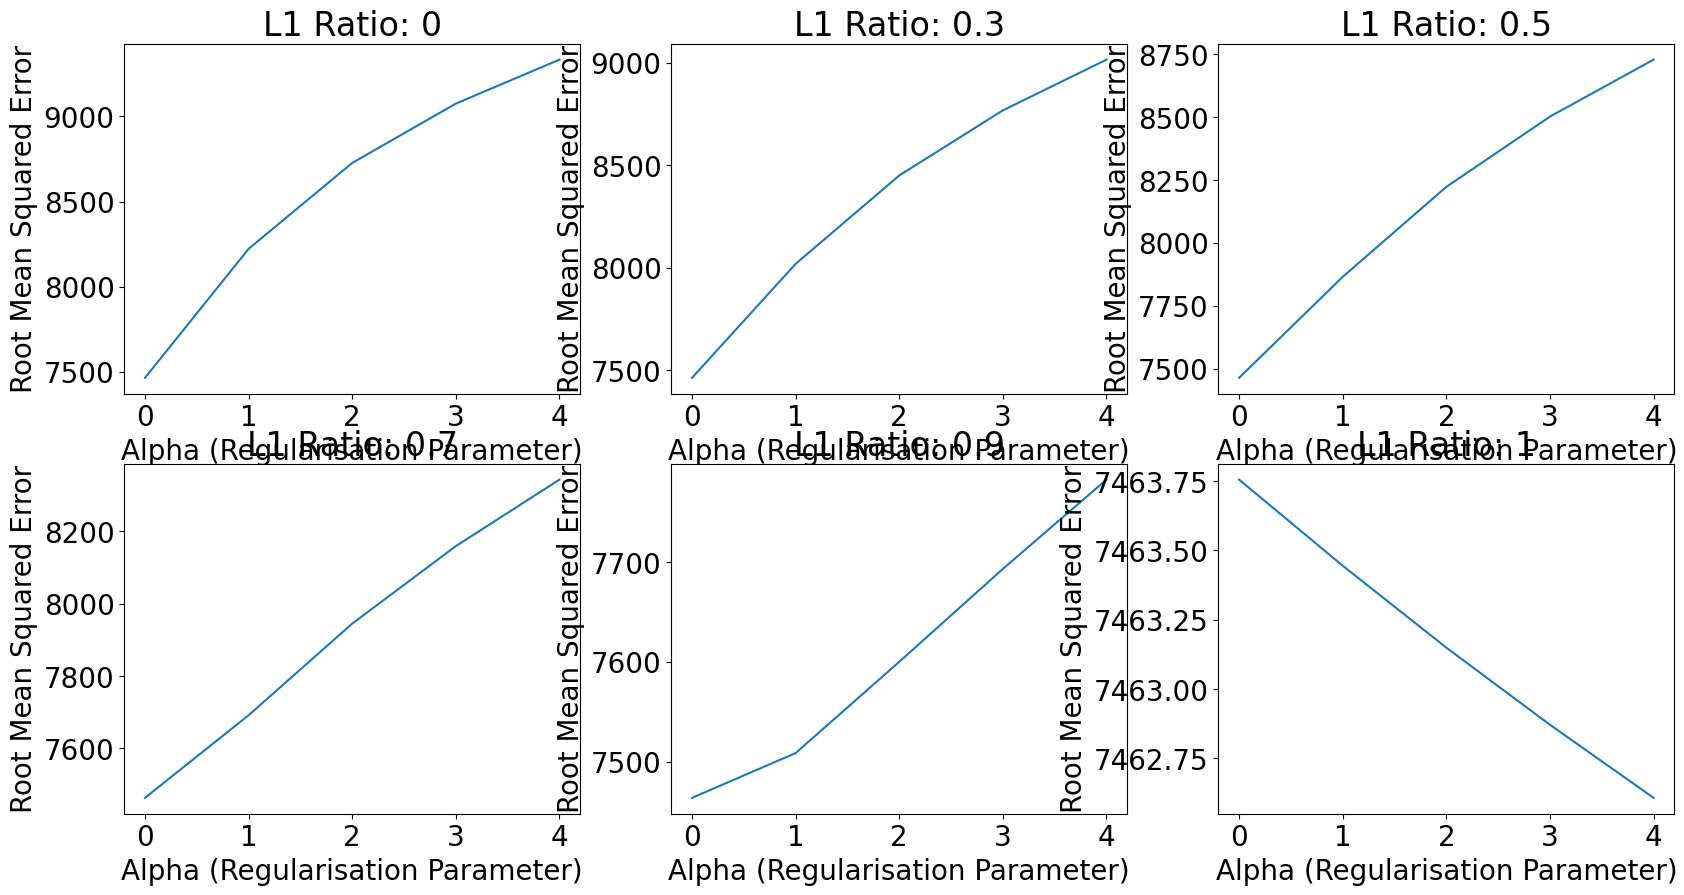

In [295]:
plt.figure(figsize=(20,10))

for i in range(len(reg.cv_results_['param_alpha'].data[::5])):
    plt.subplot(2,3,i+1)
    plt.plot(reg.cv_results_['param_alpha'].data[i::6],np.sqrt(-1 * reg.cv_results_['mean_test_score'][i::6]))
    plt.title(f"L1 Ratio: {reg.cv_results_['param_l1_ratio'].data[i::6][0]}")
    plt.xlabel('Alpha (Regularisation Parameter)')
    plt.ylabel('Root Mean Squared Error')